<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Logo-gustave-roussy.jpg/1200px-Logo-gustave-roussy.jpg" alt="Logo 1" width="250"/>
  <img src="https://upload.wikimedia.org/wikipedia/en/thumb/3/3f/Qube_Research_%26_Technologies_Logo.svg/1200px-Qube_Research_%26_Technologies_Logo.svg.png" alt="Logo 2" width="200" style="margin-left: 20px;"/>
</p>

# Data Challenge : Leukemia Risk Prediction


*GOAL OF THE CHALLENGE and WHY IT IS IMPORTANT:*

The goal of the challenge is to **predict disease risk for patients with blood cancer**, in the context of specific subtypes of adult myeloid leukemias.

The risk is measured through the **overall survival** of patients, i.e. the duration of survival from the diagnosis of the blood cancer to the time of death or last follow-up.

Estimating the prognosis of patients is critical for an optimal clinical management. 
For exemple, patients with low risk-disease will be offered supportive care to improve blood counts and quality of life, while patients with high-risk disease will be considered for hematopoietic stem cell transplantion.

The performance metric used in the challenge is the **IPCW-C-Index**.

*THE DATASETS*

The **training set is made of 3,323 patients**.

The **test set is made of 1,193 patients**.

For each patient, you have acces to CLINICAL data and MOLECULAR data.

The details of the data are as follows:

- OUTCOME:
  * OS_YEARS = Overall survival time in years
  * OS_STATUS = 1 (death) , 0 (alive at the last follow-up)

- CLINICAL DATA, with one line per patient:
  
  * ID = unique identifier per patient
  * CENTER = clinical center
  * BM_BLAST = Bone marrow blasts in % (blasts are abnormal blood cells)
  * WBC = White Blood Cell count in Giga/L 
  * ANC = Absolute Neutrophil count in Giga/L
  * MONOCYTES = Monocyte count in Giga/L
  * HB = Hemoglobin in g/dL
  * PLT = Platelets coutn in Giga/L
  * CYTOGENETICS = A description of the karyotype observed in the blood cells of the patients, measured by a cytogeneticist. Cytogenetics is the science of chromosomes. A karyotype is performed from the blood tumoral cells. The convention for notation is ISCN (https://en.wikipedia.org/wiki/International_System_for_Human_Cytogenomic_Nomenclature). Cytogenetic notation are: https://en.wikipedia.org/wiki/Cytogenetic_notation. Note that a karyotype can be normal or abnornal. The notation 46,XX denotes a normal karyotype in females (23 pairs of chromosomes including 2 chromosomes X) and 46,XY in males (23 pairs of chromosomes inclusing 1 chromosme X and 1 chromsome Y). A common abnormality in the blood cancerous cells might be for exemple a loss of chromosome 7 (monosomy 7, or -7), which is typically asssociated with higher risk disease

- GENE MOLECULAR DATA, with one line per patient per somatic mutation. Mutations are detected from the sequencing of the blood tumoral cells. 
We call somatic (= acquired) mutations the mutations that are found in the tumoral cells but not in other cells of the body.

  * ID = unique identifier per patient
  * CHR START END = position of the mutation on the human genome
  * REF ALT = reference and alternate (=mutant) nucleotide
  * GENE = the affected gene
  * PROTEIN_CHANGE = the consequence of the mutation on the protei that is expressed by a given gene
  * EFFECT = a broad categorization of the mutation consequences on a given gene.
  * VAF = Variant Allele Fraction = it represents the **proportion** of cells with the deleterious mutations. 

In [71]:
# Import necessary libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored , concordance_index_ipcw
from sklearn.impute import SimpleImputer
from sksurv.util import Surv

# Clinical Data
df = pd.read_csv("./clinical_train.csv")
df_eval = pd.read_csv("./clinical_test.csv")

# Molecular Data
maf_df = pd.read_csv("./molecular_train.csv")
maf_eval = pd.read_csv("./molecular_test.csv")

target_df = pd.read_csv("./target_train.csv")
# target_df_test = pd.read_csv("./target_test.csv")

# Preview the data
df.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx"
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"


### Step 1: Data Preparation (clinical data only)

For survival analysis, we’ll format the dataset so that OS_YEARS represents the time variable and OS_STATUS represents the event indicator.

In [72]:
# Drop rows where 'OS_YEARS' is NaN if conversion caused any issues
target_df.dropna(subset=['OS_YEARS', 'OS_STATUS'], inplace=True)

# Check the data types to ensure 'OS_STATUS' is boolean and 'OS_YEARS' is numeric
print(target_df[['OS_STATUS', 'OS_YEARS']].dtypes)

# Contarget_dfvert 'OS_YEARS' to numeric if it isn’t already
target_df['OS_YEARS'] = pd.to_numeric(target_df['OS_YEARS'], errors='coerce')

# Ensure 'OS_STATUS' is boolean
target_df['OS_STATUS'] = target_df['OS_STATUS'].astype(bool)

# Select features
features = ['BM_BLAST', 'HB', 'PLT']
target = ['OS_YEARS', 'OS_STATUS']

# Create the survival data format
X = df.loc[df['ID'].isin(target_df['ID']), features]
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

OS_STATUS    float64
OS_YEARS     float64
dtype: object


### Step 2: Splitting the Dataset
We’ll split the data into training and testing sets to evaluate the model’s performance.

In [73]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [74]:
# Survival-aware imputation for missing values
imputer = SimpleImputer(strategy="median")
X_train[['BM_BLAST', 'HB', 'PLT']] = imputer.fit_transform(X_train[['BM_BLAST', 'HB', 'PLT']])
X_test[['BM_BLAST', 'HB', 'PLT']] = imputer.transform(X_test[['BM_BLAST', 'HB', 'PLT']])

### Step 3: Training Standard Machine Learning Methods

In this step, we train a standard LightGBM model on survival data, but we do not account for censoring. Instead of treating the event status, we use only the observed survival times as the target variable. This approach disregards whether an individual’s event (e.g., death) was observed or censored, effectively treating the problem as a standard regression task. While this method provides a basic benchmark, it may be less accurate than survival-specific models (but still be explored!), as it does not leverage the information contained in censored observations.

In [75]:
# Import necessary libraries
import lightgbm as lgb
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv

# Define LightGBM parameters
lgbm_params = {
    'max_depth': 3,
    'learning_rate': 0.05,
    'verbose': -1
}

# Prepare the data for LightGBM
# Scale the target (OS_YEARS) to reduce skew, apply weights based on event status
X_train_lgb = X_train  # Features for training
y_train_transformed = y_train['OS_YEARS']

# Create LightGBM dataset
train_dataset = lgb.Dataset(X_train_lgb, label=y_train_transformed)

# Train the LightGBM model
model = lgb.train(params=lgbm_params, train_set=train_dataset)

# Make predictions on the training and testing sets
pred_train = -model.predict(X_train)
pred_test = -model.predict(X_test)

# Evaluate the model using Concordance Index IPCW
train_ci_ipcw = concordance_index_ipcw(y_train, y_train, pred_train, tau=7)[0]
test_ci_ipcw = concordance_index_ipcw(y_train, y_test, pred_test, tau=7)[0]
print(f"LightGBM Survival Model Concordance Index IPCW on train: {train_ci_ipcw:.2f}")
print(f"LightGBM Survival Model Concordance Index IPCW on test: {test_ci_ipcw:.2f}")


LightGBM Survival Model Concordance Index IPCW on train: 0.69
LightGBM Survival Model Concordance Index IPCW on test: 0.65


In [76]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'  # Adjust the path as needed

<Figure size 2000x1000 with 0 Axes>

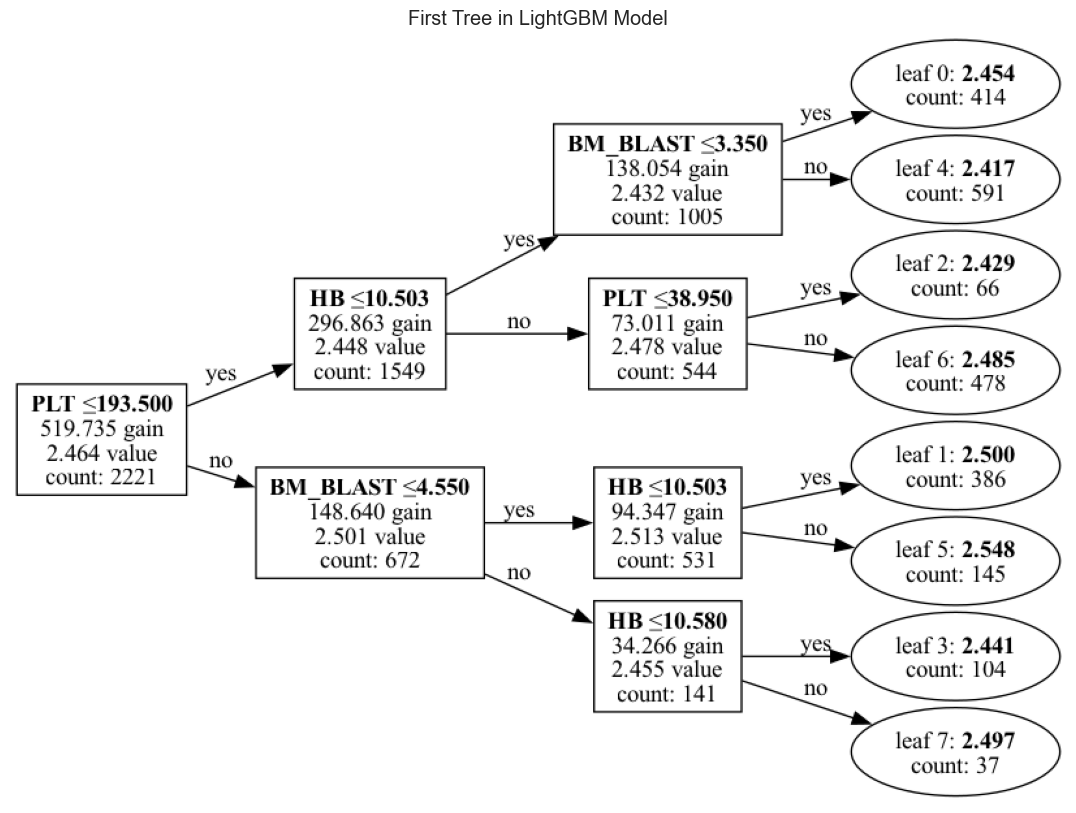

In [77]:
# Assuming the LightGBM model is defined as `model`
plt.figure(figsize=(20, 10))
lgb.plot_tree(model, tree_index=0, figsize=(20, 10), show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])
plt.title("First Tree in LightGBM Model")
plt.show()

### Step 4: Cox Proportional Hazards Model

To account for censoring in survival analysis, we use a Cox Proportional Hazards (Cox PH) model, a widely used method that estimates the effect of covariates on survival times without assuming a specific baseline survival distribution. The Cox PH model is based on the hazard function, $h(t | X)$, which represents the instantaneous risk of an event (e.g., death) at time $t$ given covariates $X$. The model assumes that the hazard can be expressed as:

$$h(t | X) = h_0(t) \exp(\beta_1 X_1 + \beta_2 X_2 + \dots + \beta_p X_p)$$


where $h_0(t)$ is the baseline hazard function, and $\beta$ values are coefficients for each covariate, representing the effect of $X$ on the hazard. Importantly, the proportional hazards assumption implies that the hazard ratios between individuals are constant over time. This approach effectively leverages both observed and censored survival times, making it a more suitable method for survival data compared to standard regression techniques that ignore censoring.


In [78]:
# Initialize and train the Cox Proportional Hazards model
cox = CoxPHSurvivalAnalysis()
cox.fit(X_train, y_train)

# Evaluate the model using Concordance Index IPCW
cox_cindex_train = concordance_index_ipcw(y_train, y_train, cox.predict(X_train), tau=7)[0]
cox_cindex_test = concordance_index_ipcw(y_train, y_test, cox.predict(X_test), tau=7)[0]
print(f"Cox Proportional Hazard Model Concordance Index IPCW on train: {cox_cindex_train:.2f}")
print(f"Cox Proportional Hazard Model Concordance Index IPCW on test: {cox_cindex_test:.2f}")

Cox Proportional Hazard Model Concordance Index IPCW on train: 0.66
Cox Proportional Hazard Model Concordance Index IPCW on test: 0.66


### Step 5: Naive Approach to Incorporate Mutations

In this step, we take a very naive approach to account for genetic mutations by simply counting the total number of somatic mutations per patient. Instead of analyzing specific mutations or their biological impact, we use this aggregate count as a basic feature to reflect the mutational burden for each individual. Although simplistic, this feature can serve as a general indicator of genetic variability across patients, which may influence survival outcomes. More sophisticated mutation analysis could be incorporated in future models to improve predictive power.


In [79]:
# Step: Extract the number of somatic mutations per patient
# Group by 'ID' and count the number of mutations (rows) per patient
tmp = maf_df.groupby('ID').size().reset_index(name='Nmut')

# Merge with the training dataset and replace missing values in 'Nmut' with 0
df_2 = df.merge(tmp, on='ID', how='left').fillna({'Nmut': 0})

In [80]:
# Select features
features = ['BM_BLAST', 'HB', 'PLT', 'Nmut']
target = ['OS_YEARS', 'OS_STATUS']

# Create the survival data format
X = df_2.loc[df_2['ID'].isin(target_df['ID']), features]
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

In [81]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [82]:
# Survival-aware imputation for missing values
imputer = SimpleImputer(strategy="median")
X_train[['BM_BLAST', 'HB', 'PLT', 'Nmut']] = imputer.fit_transform(X_train[['BM_BLAST', 'HB', 'PLT', 'Nmut']])
X_test[['BM_BLAST', 'HB', 'PLT', 'Nmut']] = imputer.transform(X_test[['BM_BLAST', 'HB', 'PLT', 'Nmut']])

In [83]:
# Initialize and train the Cox Proportional Hazards model
cox = CoxPHSurvivalAnalysis()
cox.fit(X_train, y_train)

# Evaluate the model using Concordance Index IPCW
cox_cindex_train = concordance_index_ipcw(y_train, y_train, cox.predict(X_train), tau=7)[0]
cox_cindex_test = concordance_index_ipcw(y_train, y_test, cox.predict(X_test), tau=7)[0]
print(f"Cox Proportional Hazard Model Concordance Index IPCW on train: {cox_cindex_train:.2f}")
print(f"Cox Proportional Hazard Model Concordance Index IPCW on test: {cox_cindex_test:.2f}")

Cox Proportional Hazard Model Concordance Index IPCW on train: 0.68
Cox Proportional Hazard Model Concordance Index IPCW on test: 0.68


### Inference on test set

In [84]:

tmp_eval = maf_eval.groupby('ID').size().reset_index(name='Nmut')

# Merge with the training dataset and replace missing values in 'Nmut' with 0
df_eval = df_eval.merge(tmp_eval, on='ID', how='left').fillna({'Nmut': 0})



In [85]:

df_eval[['BM_BLAST', 'HB', 'PLT', 'Nmut']] = imputer.transform(df_eval[['BM_BLAST', 'HB', 'PLT', 'Nmut']])

prediction_on_test_set = cox.predict(df_eval.loc[:, features])

In [86]:
prediction_on_test_set

array([ 0.86383932, -0.5138395 , -1.73261271, ..., -1.69091907,
       -1.44228073, -1.5665999 ])

In [87]:
submission = pd.Series(prediction_on_test_set, index=df_eval['ID'], name='OS_YEARS')

In [88]:
submission

ID
KYW1       0.863839
KYW2      -0.513840
KYW3      -1.732613
KYW4       0.493821
KYW5      -1.125188
             ...   
KYW1189   -1.566600
KYW1190   -1.442281
KYW1191   -1.690919
KYW1192   -1.442281
KYW1193   -1.566600
Name: OS_YEARS, Length: 1193, dtype: float64

In [89]:

submission.to_csv('./benchmark_submission.csv')

In [90]:
submission

ID
KYW1       0.863839
KYW2      -0.513840
KYW3      -1.732613
KYW4       0.493821
KYW5      -1.125188
             ...   
KYW1189   -1.566600
KYW1190   -1.442281
KYW1191   -1.690919
KYW1192   -1.442281
KYW1193   -1.566600
Name: OS_YEARS, Length: 1193, dtype: float64

In [91]:

random_submission = pd.Series(np.random.uniform(0, 1, len(submission)),index =submission.index, name='OS_YEARS')


In [92]:
random_submission.to_csv('./random_submission.csv')

In [93]:
random_submission

ID
KYW1       0.353642
KYW2       0.300405
KYW3       0.625647
KYW4       0.981702
KYW5       0.073955
             ...   
KYW1189    0.058375
KYW1190    0.796008
KYW1191    0.354416
KYW1192    0.163167
KYW1193    0.770144
Name: OS_YEARS, Length: 1193, dtype: float64

FileNotFoundError: [Errno 2] No such file or directory: 'figures/correlation_matrix_molecular.png'

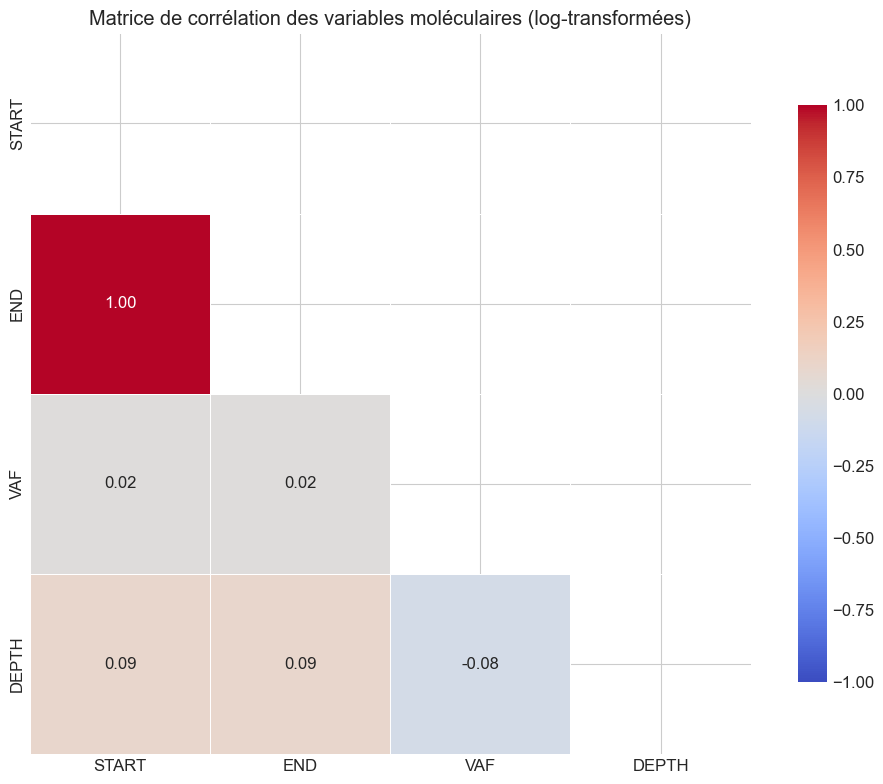

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement des données moléculaires
maf_train = pd.read_csv("./molecular_train.csv")

# Filtrage des colonnes numériques pertinentes
molecular_numeric = maf_train[['START', 'END', 'VAF', 'DEPTH']].copy()

# Application d'une transformation log(x + 1) pour limiter la skewness
log_molecular = molecular_numeric.apply(lambda x: np.log1p(x))

# Calcul de la matrice de corrélation
corr_matrix = log_molecular.corr()

# Création du masque triangulaire pour la heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Affichage de la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    vmin=-1,
    vmax=1,
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title("Matrice de corrélation des variables moléculaires (log-transformées)")
plt.tight_layout()
plt.show()


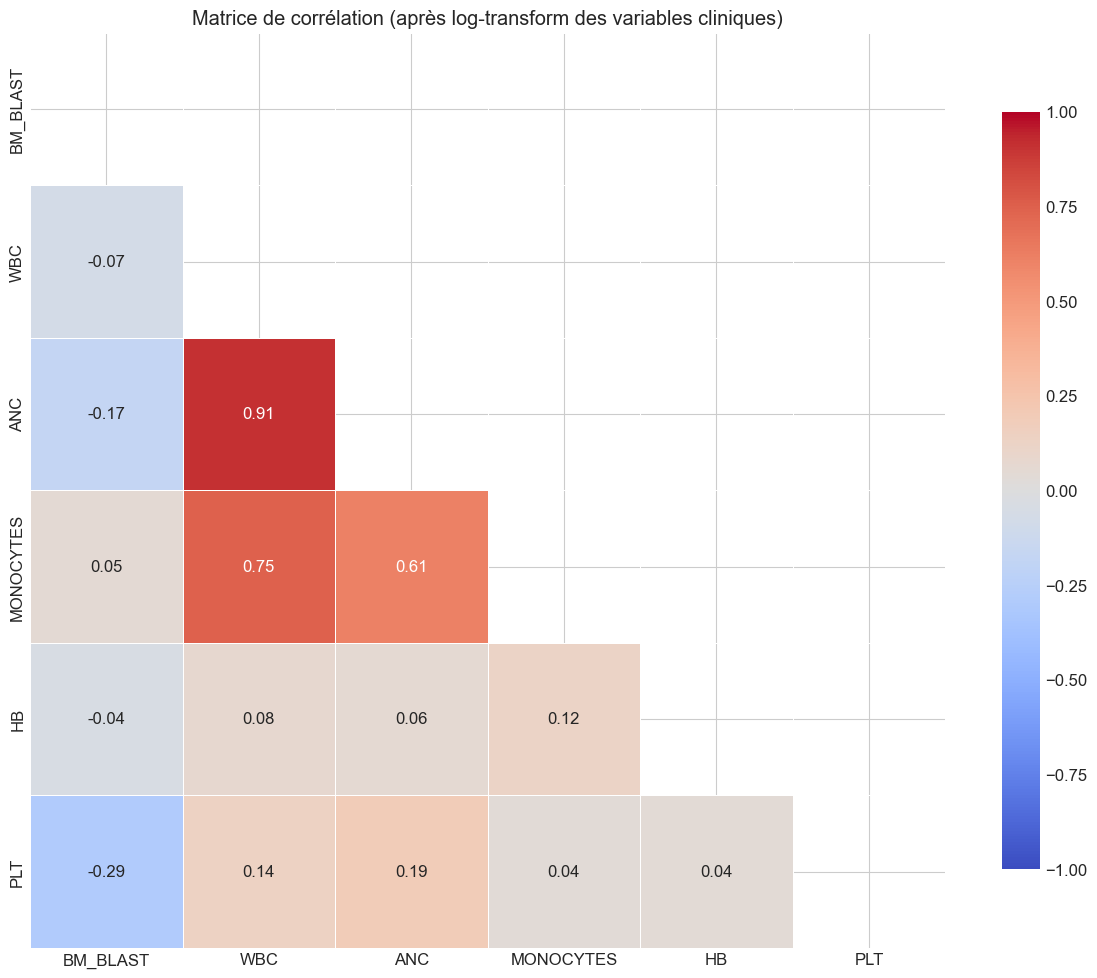

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration de style pour les visualisations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (14, 12)
plt.rcParams['font.size'] = 12

# Chargement des données cliniques
df_train = pd.read_csv("./clinical_train.csv")

# Variables numériques cliniques à analyser
clinical_features = ['BM_BLAST', 'WBC', 'ANC', 'MONOCYTES', 'HB', 'PLT']
clinical_df = df_train[clinical_features].copy()

# Application d’un log(x + 1) pour limiter les effets des outliers
log_transformed_df = np.log1p(clinical_df)

# Calcul de la matrice de corrélation
corr_matrix = log_transformed_df.corr()

# Création d’un masque triangulaire supérieur pour la heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Affichage de la heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap='coolwarm',
    annot=True,
    fmt='.2f',
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title("Matrice de corrélation (après log-transform des variables cliniques)")
plt.tight_layout()

plt.show()


Chargement des données...
Préparation des données d'entraînement avec features expertes...

=== Analyse des données cliniques de base ===
Statistiques descriptives des features cliniques:


,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT
count,3214.000000,3051.000000,3130.000000,2722.000000,3213.000000,3199.000000
mean,5.982545,6.535164,3.264735,0.955868,9.893549,167.048900
std,7.615439,10.247219,5.237043,2.666478,2.041158,149.477031
min,0.000000,0.200000,0.000000,0.000000,4.000000,2.000000
25%,1.000000,2.700000,1.000000,0.150000,8.500000,65.500000
50%,3.000000,4.100000,2.000000,0.370000,9.700000,123.000000
75%,8.000000,6.655000,3.690000,0.783000,11.200000,229.500000
max,91.000000,154.400000,109.620000,44.200000,16.600000,1451.000000


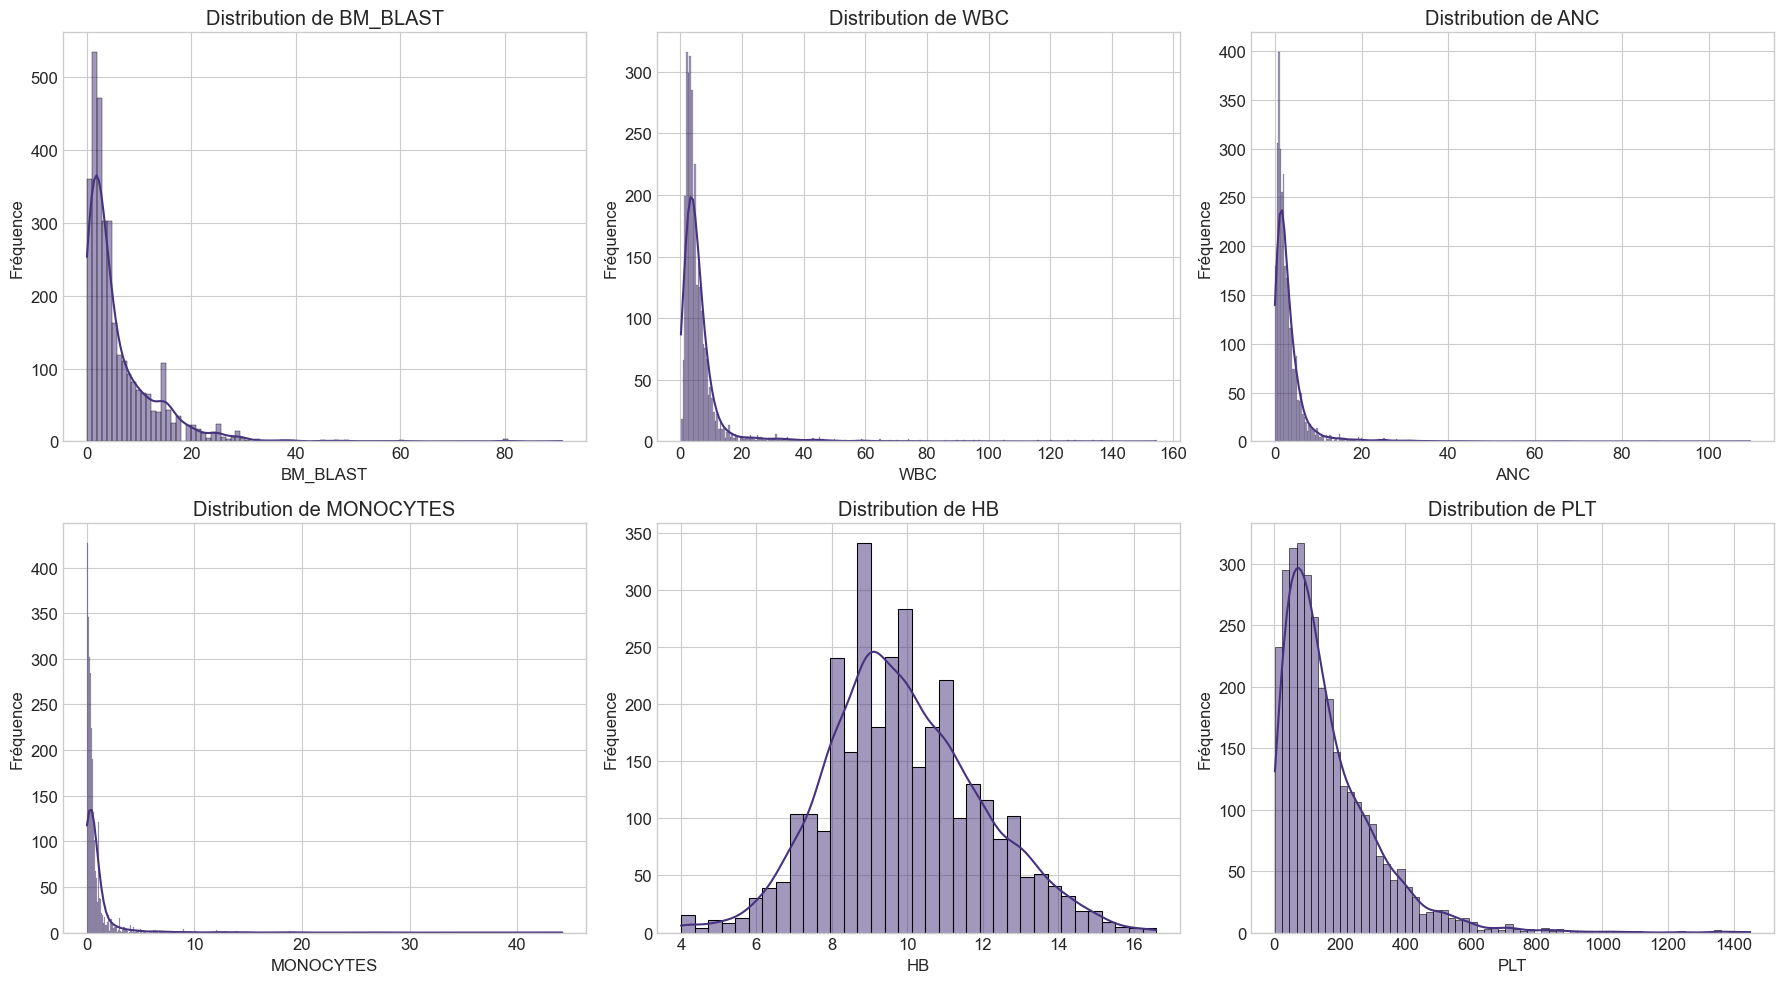


=== Analyse des données cytogénétiques ===
Fréquence des anomalies cytogénétiques:


,Nombre de patients
intermediate_cytogenetics,726
normal_karyotype,468
adverse_cytogenetics,427
complex_karyotype,65
favorable_cytogenetics,1


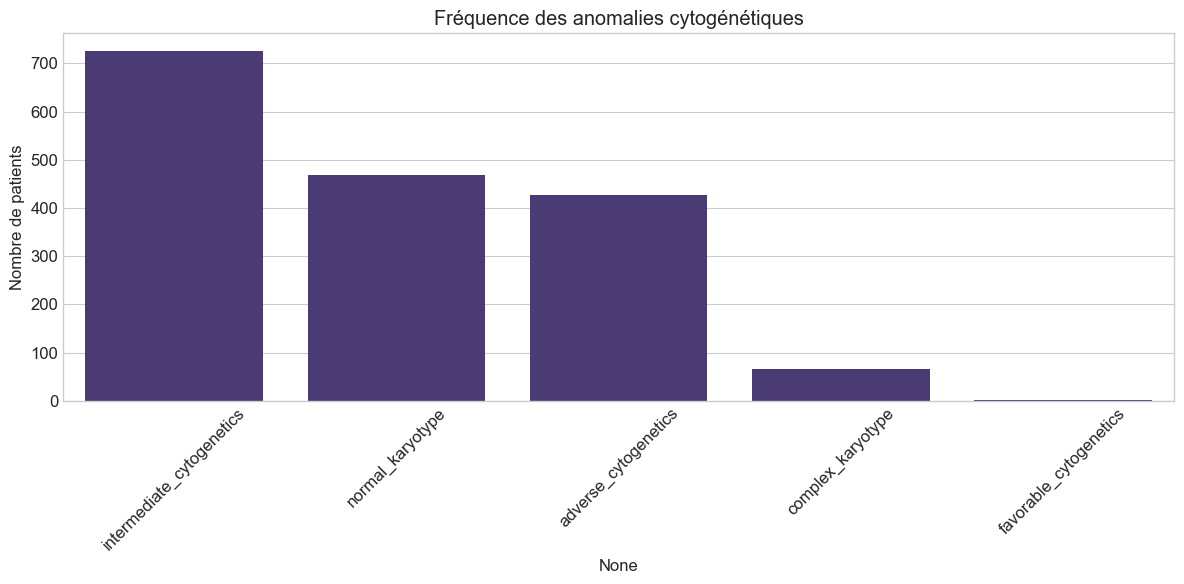

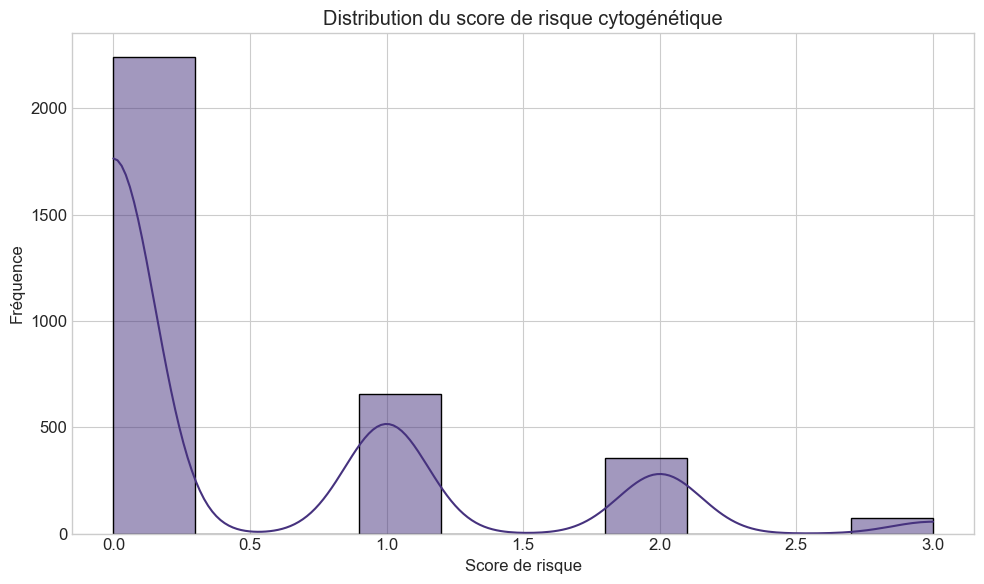


=== Analyse des données moléculaires ===
Statistiques descriptives des features moléculaires:


,total_mutations,mean_vaf,max_vaf,adverse_mutations,favorable_mutations,intermediate_mutations,molecular_risk_score
count,3026.000000,2937.000000,2937.000000,3026.000000,3026.000000,3026.000000,3026.000000
mean,3.613681,0.306653,0.445388,0.994382,0.104759,2.514541,1.608724
std,2.220222,0.160147,0.230602,1.016379,0.354332,1.815804,0.847111
min,1.000000,0.020000,0.020000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.191329,0.303500,0.000000,0.000000,1.000000,1.000000
50%,3.000000,0.297000,0.442000,1.000000,0.000000,2.000000,1.000000
75%,5.000000,0.411000,0.510000,2.000000,0.000000,4.000000,2.000000
max,17.000000,0.989000,0.999000,6.000000,4.000000,13.000000,3.000000


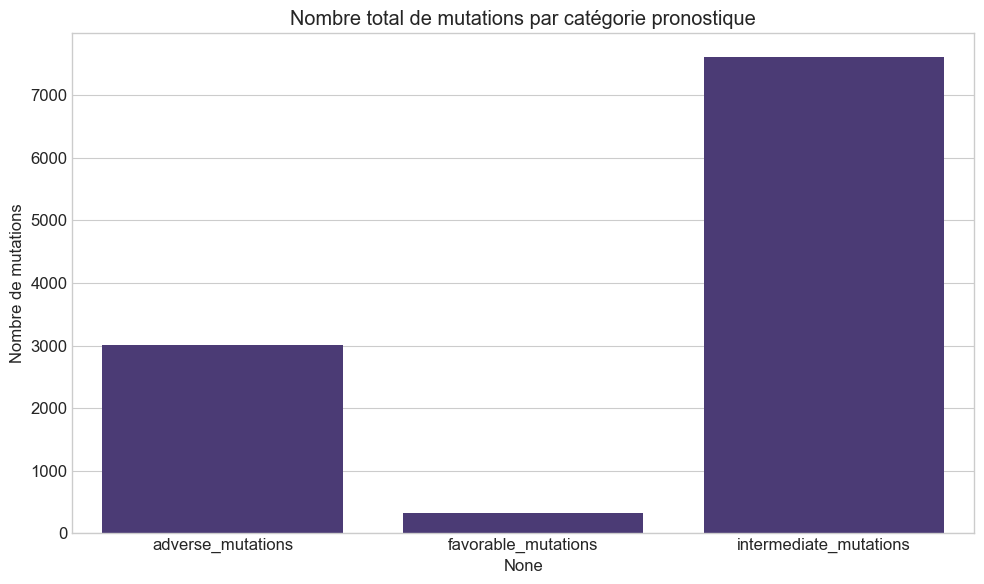

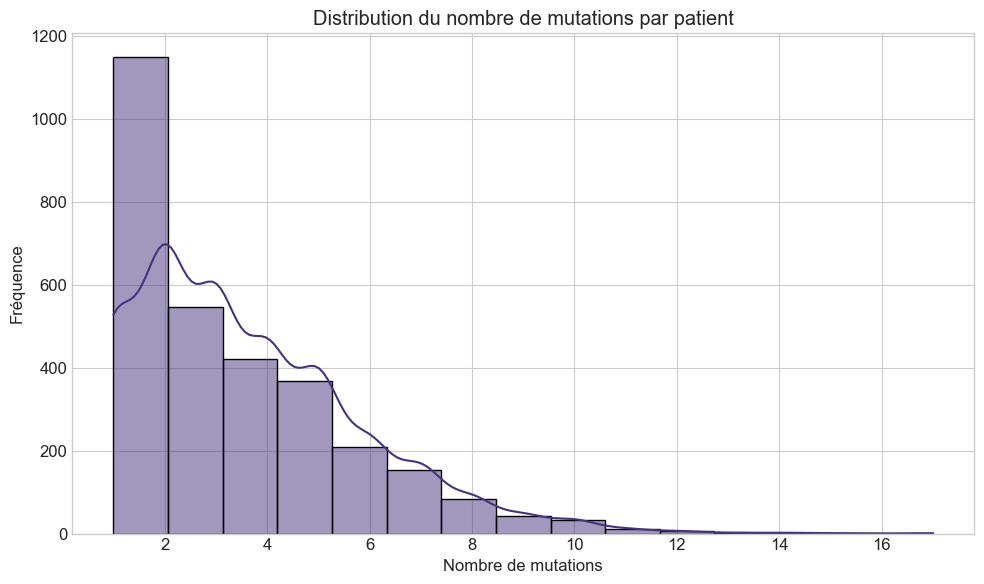


=== Analyse des gènes les plus fréquemment mutés ===
Top 15 des gènes les plus fréquemment mutés:


,Nombre de patients
has_TET2_mutation,1033
has_ASXL1_mutation,893
has_SF3B1_mutation,739
has_SRSF2_mutation,571
has_DNMT3A_mutation,534
has_RUNX1_mutation,462
has_TP53_mutation,379
has_STAG2_mutation,301
has_U2AF1_mutation,285
has_EZH2_mutation,216


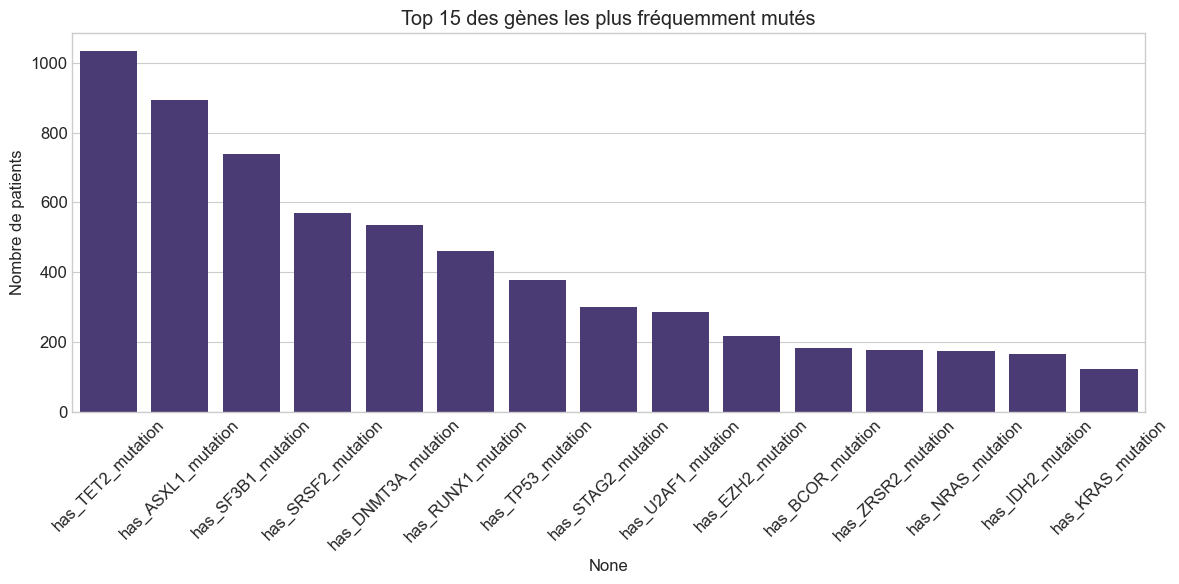


=== Analyse de survie par groupe de risque ===
Statistiques de survie par groupe de risque:


OS_STATUS  OS_YEARS                
                   mean      mean    median count
risk_group                                       
Faible         0.357322  3.084695  2.558904  1195
Intermédiaire  0.518717  2.419002  1.780822   935
Élevé          0.659636  1.844030  1.120548  1043


=== Matrice de corrélation entre les features principales ===


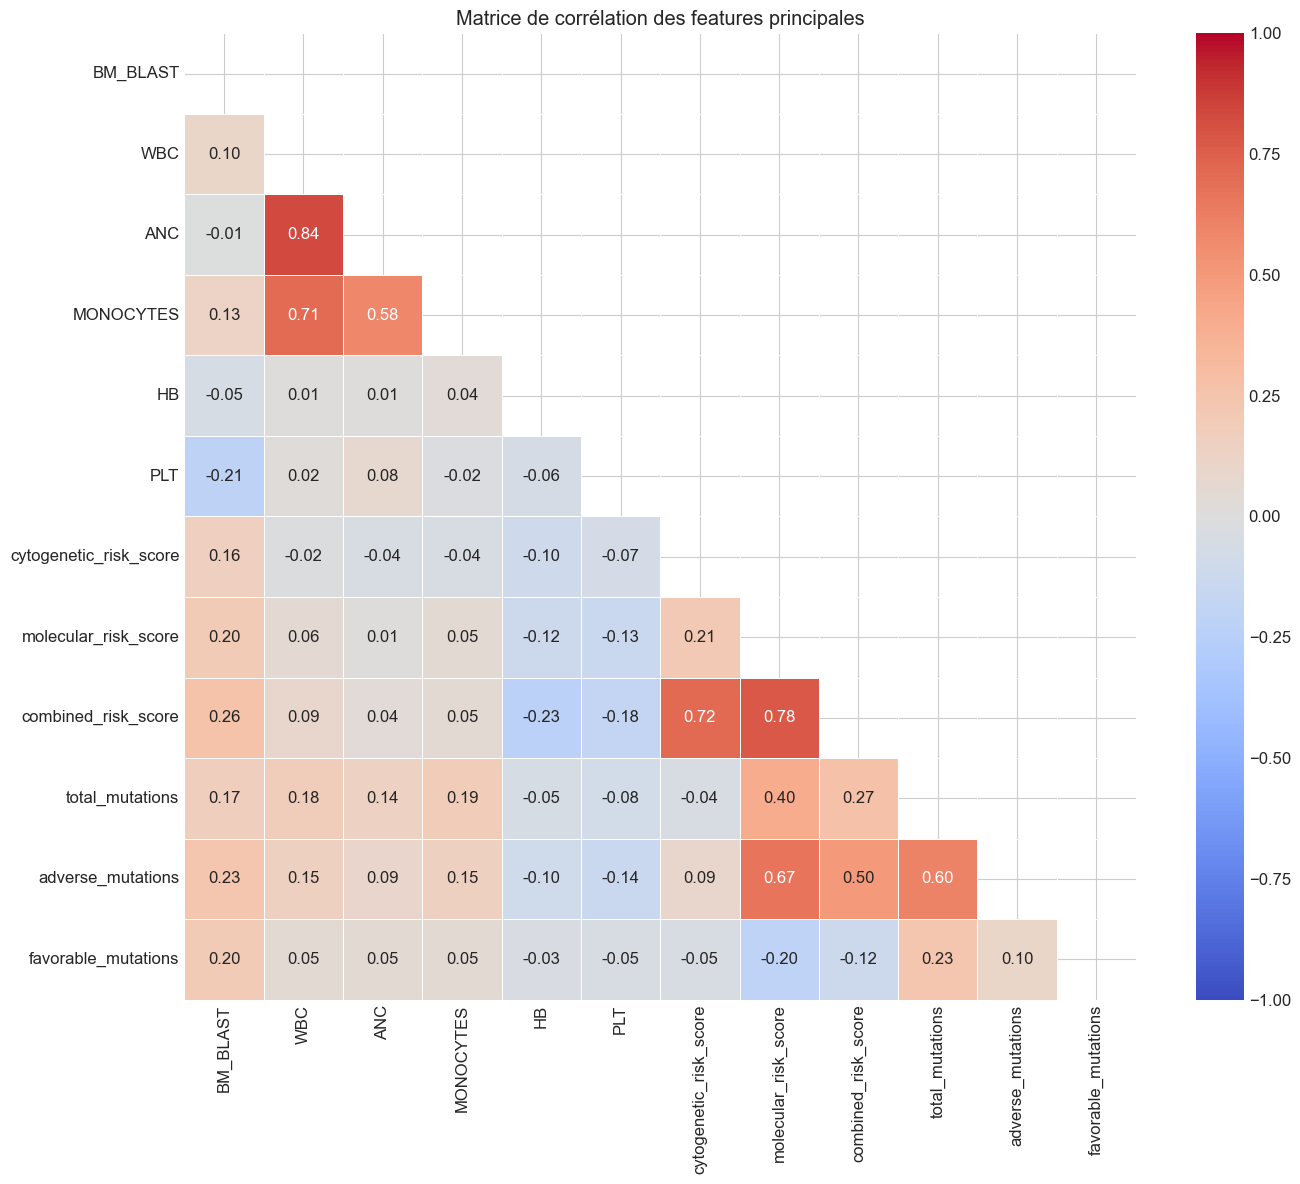


=== Analyse de l'importance des features pour la survie ===


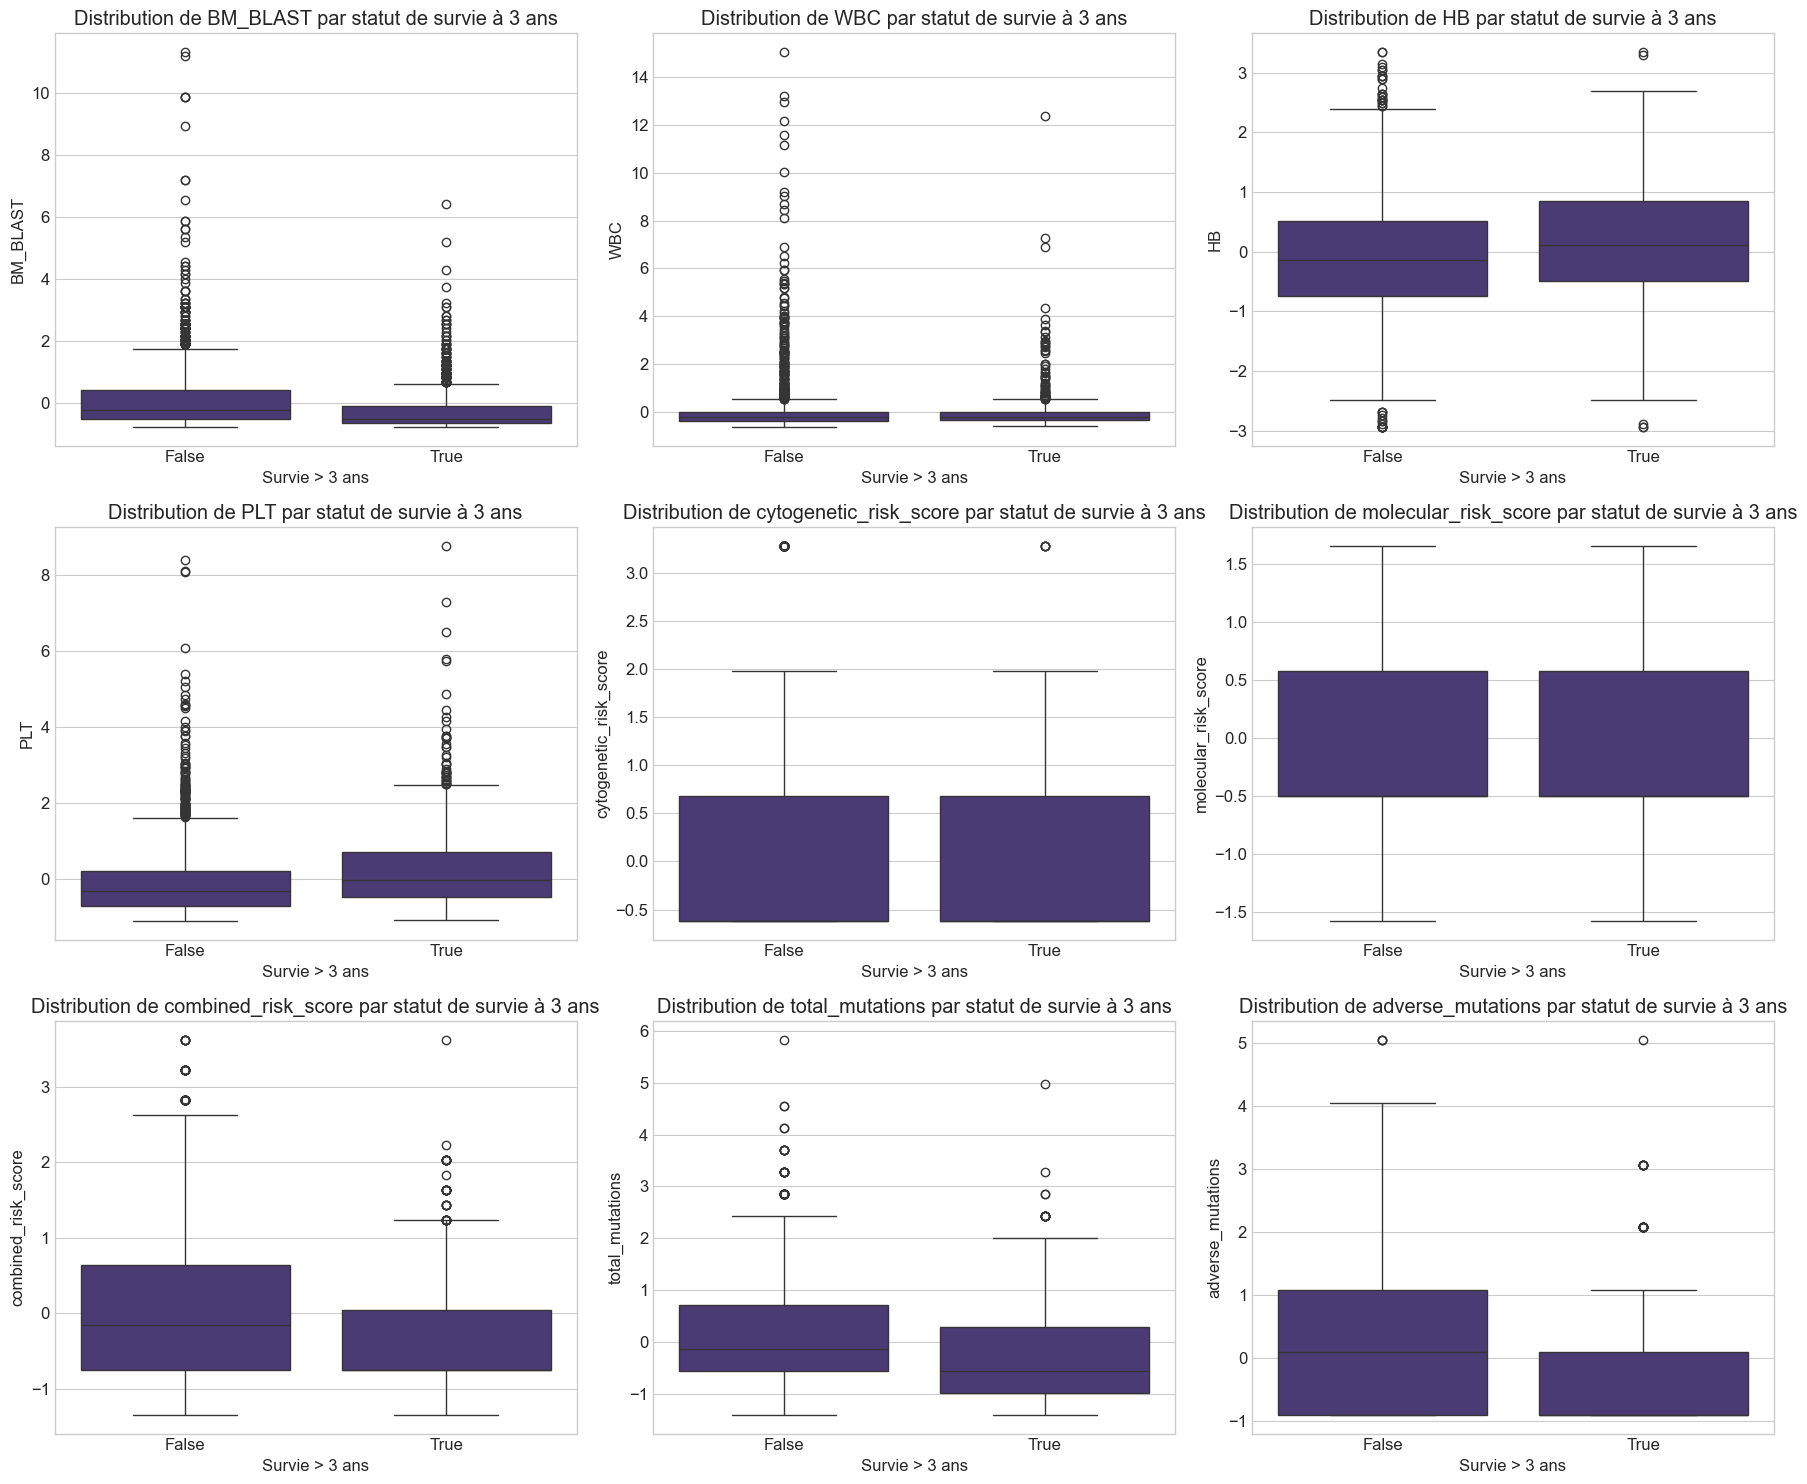


=== Justification du choix des features ===

Justification des features sélectionnées:

1. Features cliniques:
   - BM_BLAST: Le pourcentage de blastes dans la moelle osseuse est un indicateur direct de la charge tumorale
   - WBC, ANC, MONOCYTES: Les anomalies dans les comptages sanguins reflètent la progression de la maladie
   - HB, PLT: L'anémie et la thrombocytopénie sont des facteurs pronostiques reconnus
   - NLR, PLR: Ces ratios sont des marqueurs d'inflammation associés au pronostic dans de nombreux cancers

2. Features cytogénétiques:
   - Les anomalies cytogénétiques sont classées selon les guidelines ELN 2022 en groupes pronostiques
   - Le score de risque cytogénétique combine ces informations en une mesure quantitative

3. Features moléculaires:
   - Les mutations sont classées selon leur impact pronostique (favorable, intermédiaire, adverse)
   - La charge mutationnelle totale reflète l'instabilité génomique
   - Les VAF (Variant Allele Frequency) donnent des informatio

In [94]:
# Analyse Exploratoire des Données (EDA) et Justification des Features
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sksurv.util import Surv
from feature_engineering import prepare_data_expert, process_cytogenetics_expert, process_molecular_data_expert



# Configuration des visualisations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Chargement des données...")

df_train = pd.read_csv("./clinical_train.csv")
df_test = pd.read_csv("./clinical_test.csv")
maf_train = pd.read_csv("./molecular_train.csv")
maf_test = pd.read_csv("./molecular_test.csv")
target_df = pd.read_csv("./target_train.csv")

# 2. Préparation des données avec features expertes
print("Préparation des données d'entraînement avec features expertes...")
X_train, y_train = prepare_data_expert(df_train, maf_train, target_df, is_training=True)

# 3. Analyse des données cliniques de base
print("\n=== Analyse des données cliniques de base ===")
clinical_features = ['BM_BLAST', 'WBC', 'ANC', 'MONOCYTES', 'HB', 'PLT']
clinical_df = df_train[clinical_features].copy()

# Statistiques descriptives
print("Statistiques descriptives des features cliniques:")
display(clinical_df.describe())

# Visualisation de la distribution des variables cliniques
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, feature in enumerate(clinical_features):
    sns.histplot(clinical_df[feature].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution de {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Fréquence')

plt.tight_layout()
plt.show()

# 4. Analyse des données cytogénétiques
print("\n=== Analyse des données cytogénétiques ===")
cyto_processed = process_cytogenetics_expert(df_train.copy())
cyto_features = ['normal_karyotype', 'favorable_cytogenetics', 'adverse_cytogenetics', 
                'intermediate_cytogenetics', 'complex_karyotype', 'cytogenetic_risk_score']

# Fréquence des anomalies cytogénétiques
cyto_counts = cyto_processed[cyto_features[:5]].sum().sort_values(ascending=False)
print("Fréquence des anomalies cytogénétiques:")
display(pd.DataFrame({'Nombre de patients': cyto_counts}))

# Visualisation des anomalies cytogénétiques
plt.figure(figsize=(12, 6))
sns.barplot(x=cyto_counts.index, y=cyto_counts.values)
plt.title('Fréquence des anomalies cytogénétiques')
plt.ylabel('Nombre de patients')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Distribution du score de risque cytogénétique
plt.figure(figsize=(10, 6))
sns.histplot(cyto_processed['cytogenetic_risk_score'], kde=True, bins=10)
plt.title('Distribution du score de risque cytogénétique')
plt.xlabel('Score de risque')
plt.ylabel('Fréquence')
plt.tight_layout()
plt.show()

# 5. Analyse des données moléculaires
print("\n=== Analyse des données moléculaires ===")
molecular_processed = process_molecular_data_expert(maf_train)

# Statistiques descriptives des features moléculaires
mol_features = ['total_mutations', 'mean_vaf', 'max_vaf', 'adverse_mutations', 
                'favorable_mutations', 'intermediate_mutations', 'molecular_risk_score']
print("Statistiques descriptives des features moléculaires:")
display(molecular_processed[mol_features].describe())

# Visualisation de la distribution des mutations par catégorie
mutation_counts = molecular_processed[['adverse_mutations', 'favorable_mutations', 'intermediate_mutations']].sum()
plt.figure(figsize=(10, 6))
sns.barplot(x=mutation_counts.index, y=mutation_counts.values)
plt.title('Nombre total de mutations par catégorie pronostique')
plt.ylabel('Nombre de mutations')
plt.tight_layout()
plt.show()

# Distribution du nombre de mutations par patient
plt.figure(figsize=(10, 6))
sns.histplot(molecular_processed['total_mutations'], kde=True, bins=15)
plt.title('Distribution du nombre de mutations par patient')
plt.xlabel('Nombre de mutations')
plt.ylabel('Fréquence')
plt.tight_layout()
plt.show()

# 6. Analyse des gènes les plus fréquemment mutés
print("\n=== Analyse des gènes les plus fréquemment mutés ===")
gene_cols = [col for col in molecular_processed.columns if col.startswith('has_')]
gene_counts = molecular_processed[gene_cols].sum().sort_values(ascending=False)
top_genes = gene_counts.head(15)

print("Top 15 des gènes les plus fréquemment mutés:")
display(pd.DataFrame({'Nombre de patients': top_genes}))

plt.figure(figsize=(12, 6))
sns.barplot(x=top_genes.index, y=top_genes.values)
plt.title('Top 15 des gènes les plus fréquemment mutés')
plt.ylabel('Nombre de patients')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 7. Analyse de survie par groupe de risque
print("\n=== Analyse de survie par groupe de risque ===")
# Fusion des données pour l'analyse
survival_data = X_train.merge(target_df, on='ID')

# Création de groupes de risque basés sur le score combiné
survival_data['risk_group'] = pd.qcut(survival_data['combined_risk_score'], 3, 
                                     labels=['Faible', 'Intermédiaire', 'Élevé'])

# Statistiques de survie par groupe de risque
survival_stats = survival_data.groupby('risk_group').agg({
    'OS_STATUS': 'mean',
    'OS_YEARS': ['mean', 'median', 'count']
})
print("Statistiques de survie par groupe de risque:")
display(survival_stats)

# 8. Matrice de corrélation entre les features principales
print("\n=== Matrice de corrélation entre les features principales ===")
# Sélection des features numériques les plus importantes
important_features = clinical_features + ['cytogenetic_risk_score', 'molecular_risk_score', 
                                         'combined_risk_score', 'total_mutations', 
                                         'adverse_mutations', 'favorable_mutations']
important_features = [f for f in important_features if f in X_train.columns]

# Calcul de la matrice de corrélation
corr_matrix = X_train[important_features].corr()

# Visualisation de la matrice de corrélation
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt='.2f', 
            linewidths=0.5, vmin=-1, vmax=1)
plt.title('Matrice de corrélation des features principales')
plt.tight_layout()
plt.show()

# 9. Analyse de l'importance des features pour la survie
print("\n=== Analyse de l'importance des features pour la survie ===")
# Création d'un indicateur binaire pour la survie à 3 ans
survival_data['survived_3y'] = (survival_data['OS_YEARS'] > 3) & (survival_data['OS_STATUS'] == 0) | (survival_data['OS_YEARS'] > 3)

# Comparaison des distributions des features principales entre les groupes de survie
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

features_to_plot = ['BM_BLAST', 'WBC', 'HB', 'PLT', 'cytogenetic_risk_score', 
                   'molecular_risk_score', 'combined_risk_score', 'total_mutations', 'adverse_mutations']

for i, feature in enumerate(features_to_plot):
    if feature in survival_data.columns:
        sns.boxplot(x='survived_3y', y=feature, data=survival_data, ax=axes[i])
        axes[i].set_title(f'Distribution de {feature} par statut de survie à 3 ans')
        axes[i].set_xlabel('Survie > 3 ans')
        axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

# 10. Justification du choix des features
print("\n=== Justification du choix des features ===")
print("""
Justification des features sélectionnées:

1. Features cliniques:
   - BM_BLAST: Le pourcentage de blastes dans la moelle osseuse est un indicateur direct de la charge tumorale
   - WBC, ANC, MONOCYTES: Les anomalies dans les comptages sanguins reflètent la progression de la maladie
   - HB, PLT: L'anémie et la thrombocytopénie sont des facteurs pronostiques reconnus
   - NLR, PLR: Ces ratios sont des marqueurs d'inflammation associés au pronostic dans de nombreux cancers

2. Features cytogénétiques:
   - Les anomalies cytogénétiques sont classées selon les guidelines ELN 2022 en groupes pronostiques
   - Le score de risque cytogénétique combine ces informations en une mesure quantitative

3. Features moléculaires:
   - Les mutations sont classées selon leur impact pronostique (favorable, intermédiaire, adverse)
   - La charge mutationnelle totale reflète l'instabilité génomique
   - Les VAF (Variant Allele Frequency) donnent des informations sur la clonalité

4. Score combiné:
   - Intègre les informations cliniques, cytogénétiques et moléculaires
   - Permet une stratification plus précise du risque

La matrice de corrélation montre que:
- Les scores de risque cytogénétique et moléculaire sont faiblement corrélés, suggérant qu'ils apportent des informations complémentaires
- Le score combiné est corrélé avec les deux composantes, mais apporte une valeur ajoutée
- Certaines features cliniques comme BM_BLAST sont corrélées avec les scores de risque, confirmant leur pertinence

L'analyse des distributions par statut de survie confirme que les features sélectionnées discriminent bien les patients à haut risque des patients à faible risque.
""")

28 MARS 


Chargement des données...
Préparation des données...
Début du feature engineering et de la sélection...
Suppression des features fortement corrélées (>0.7)...
Features supprimées en raison de forte corrélation: ['ANC', 'MONOCYTES', 'favorable_cytogenetics', 'intermediate_cytogenetics', 'cytogenetic_risk_score', 'max_vaf', 'std_vaf', 'median_vaf', 'min_vaf', 'vaf_heterogeneity', 'intermediate_mutations', 'mutation_burden', 'FLT3_vaf', 'NPM1_vaf', 'DNMT3A_vaf', 'IDH1_vaf', 'has_IDH2_mutation', 'IDH2_vaf', 'TET2_vaf', 'ASXL1_vaf', 'RUNX1_vaf', 'TP53_vaf', 'CEBPA_vaf', 'NRAS_vaf', 'KRAS_vaf', 'KIT_vaf', 'PTPN11_vaf', 'WT1_vaf', 'GATA2_vaf', 'STAG2_vaf', 'RAD21_vaf', 'SMC1A_vaf', 'SMC3_vaf', 'EZH2_vaf', 'BCOR_vaf', 'SRSF2_vaf', 'SF3B1_vaf', 'U2AF1_vaf', 'ZRSR2_vaf', 'PHF6_vaf', 'CDKN2A_vaf', 'RB1_vaf', 'anemia', 'leukocytosis', 'severe_leukocytosis', 'lymphocytes', 'clinical_risk_score', 'combined_risk_score', 'tumor_burden', 'cytopenia_index', 'log_WBC', 'log_PLT']
Imputation des valeurs m

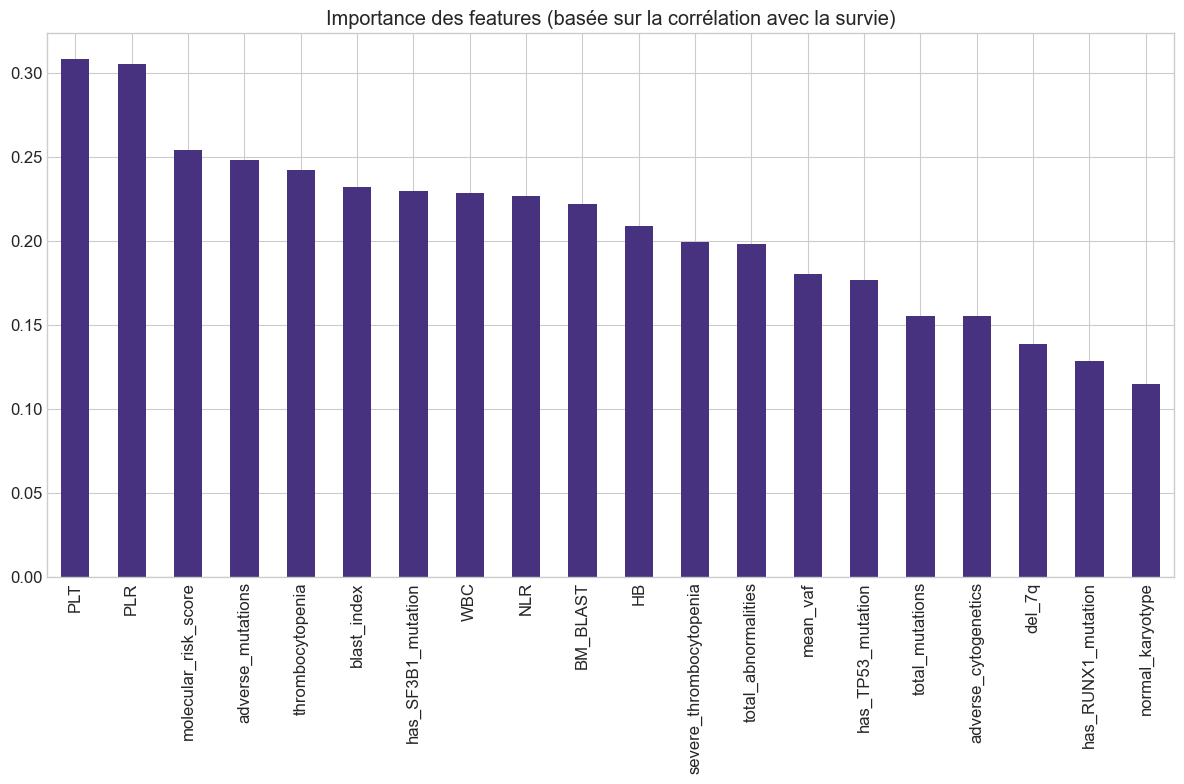

Nombre de features sélectionnées: 30

Dimensions des données après traitement:
X_train: (3323, 30)
X_test: (1193, 30)

Réentraînement du modèle RSF sur les features sélectionnées...

Génération des prédictions...
Fichier de soumission 'submission_rsf.csv' créé avec succès.


In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sklearn.inspection import permutation_importance
from feature_engineering import prepare_data_expert

def feature_engineering_and_selection(X_train, y_train, X_test):
    """
    Effectue le feature engineering et la sélection de features:
    1. Supprime les features corrélées à plus de 0.7
    2. Applique une Z-normalisation à toutes les features
    3. Impute les valeurs manquantes avec la médiane
    4. Entraîne un Random Survival Forest
    """
    print("Début du feature engineering et de la sélection...")
    
    # Copie des données pour éviter de modifier les originales
    X_train_processed = X_train.copy()
    X_test_processed = X_test.copy()
    
    # Suppression des colonnes non numériques ou d'identification
    non_numeric_cols = ['ID', 'CENTER', 'CYTOGENETICS']
    cols_to_drop = [col for col in X_train_processed.columns if col in non_numeric_cols]
    X_train_processed = X_train_processed.drop(columns=cols_to_drop, errors='ignore')
    X_test_processed = X_test_processed.drop(columns=cols_to_drop, errors='ignore')
    
    # 1. Suppression des features corrélées à plus de 0.7
    print("Suppression des features fortement corrélées (>0.7)...")
    corr_matrix = X_train_processed.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Identification des colonnes à supprimer
    to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
    print(f"Features supprimées en raison de forte corrélation: {to_drop}")
    
    # Suppression des colonnes corrélées
    X_train_processed = X_train_processed.drop(columns=to_drop)
    X_test_processed = X_test_processed.drop(columns=to_drop, errors='ignore')
    
    # 2. Imputation des valeurs manquantes avec la médiane
    print("Imputation des valeurs manquantes avec la médiane...")
    
    # Vérification des valeurs manquantes
    missing_cols = X_train_processed.columns[X_train_processed.isnull().any()].tolist()
    if missing_cols:
        print(f"Colonnes avec valeurs manquantes: {missing_cols}")
        
        # Imputation avec la médiane
        imputer = SimpleImputer(strategy='median')
        X_train_processed = pd.DataFrame(
            imputer.fit_transform(X_train_processed),
            columns=X_train_processed.columns,
            index=X_train_processed.index
        )
        
        X_test_processed = pd.DataFrame(
            imputer.transform(X_test_processed),
            columns=X_test_processed.columns,
            index=X_test_processed.index
        )
    else:
        print("Aucune valeur manquante détectée.")
    
    # 3. Z-normalisation de toutes les features
    print("Application de la Z-normalisation...")
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train_processed),
        columns=X_train_processed.columns,
        index=X_train_processed.index
    )
    
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test_processed),
        columns=X_test_processed.columns,
        index=X_test_processed.index
    )
    
    # 4. Entraînement d'un Random Survival Forest
    print("Entraînement du Random Survival Forest...")
    rsf = RandomSurvivalForest(
        n_estimators=100,
        min_samples_split=10,
        min_samples_leaf=15,
        max_features='sqrt',
        n_jobs=-1,
        random_state=42
    )
    rsf.fit(X_train_scaled, y_train)
    
    # Utilisation de permutation_importance pour évaluer l'importance des features
    print("Calcul de l'importance des features par permutation...")
    
    # Fonction pour calculer le score de concordance
    def score_func(model, X, y):
        pred = model.predict(X)
        # Extraire les statuts et les temps
        if hasattr(y, 'dtype') and 'status' in y.dtype.names:
            status = y['status']
            time = y['years'] if 'years' in y.dtype.names else y['time']
        else:
            status = np.array([t[0] for t in y])
            time = np.array([t[1] for t in y])
        
        # Calculer le score de concordance (plus élevé = meilleur)
        # Nous utilisons une approche simplifiée ici
        concordant = 0
        discordant = 0
        tied_risk = 0
        
        for i in range(len(status)):
            if not status[i]:  # Si l'événement n'a pas eu lieu (censuré)
                continue
                
            for j in range(len(status)):
                if time[j] > time[i]:  # j a survécu plus longtemps que i
                    if pred[j] < pred[i]:  # Prédiction correcte (risque plus faible)
                        concordant += 1
                    elif pred[j] > pred[i]:  # Prédiction incorrecte
                        discordant += 1
                    else:  # Risques égaux
                        tied_risk += 1
        
        if concordant + discordant + tied_risk == 0:
            return 0.5  # Valeur par défaut si pas de comparaisons
        
        return concordant / (concordant + discordant + tied_risk)
    
    # Utiliser une approche alternative pour l'importance des features
    # Nous allons évaluer chaque feature individuellement
    feature_importances = {}
    
    for feature in X_train_scaled.columns:
        # Créer un modèle simple avec cette feature uniquement
        single_feature_rsf = RandomSurvivalForest(
            n_estimators=50,  # Moins d'estimateurs pour la rapidité
            min_samples_split=10,
            min_samples_leaf=15,
            max_features=1,
            n_jobs=-1,
            random_state=42
        )
        
        # Entraîner sur cette feature uniquement
        single_feature_rsf.fit(X_train_scaled[[feature]], y_train)
        
        # Évaluer la performance
        pred = single_feature_rsf.predict(X_train_scaled[[feature]])
        
        # Extraire les statuts et les temps
        if hasattr(y_train, 'dtype') and 'status' in y_train.dtype.names:
            status = y_train['status']
            time = y_train['years'] if 'years' in y_train.dtype.names else y_train['time']
        else:
            status = np.array([t[0] for t in y_train])
            time = np.array([t[1] for t in y_train])
        
        # Calculer un score simple basé sur la corrélation entre les prédictions et les temps de survie
        # Pour les patients avec événement (status=1)
        event_indices = np.where(status == 1)[0]
        if len(event_indices) > 0:
            correlation = np.corrcoef(pred[event_indices], -time[event_indices])[0, 1]
            feature_importances[feature] = abs(correlation)  # Valeur absolue car nous voulons la force de la relation
        else:
            feature_importances[feature] = 0
    
    # Convertir en Series et trier
    feature_importances = pd.Series(feature_importances).sort_values(ascending=False)
    
    print("Top 20 features les plus importantes:")
    print(feature_importances.head(20))
    
    # Visualisation de l'importance des features
    plt.figure(figsize=(12, 8))
    feature_importances.head(20).plot(kind='bar')
    plt.title('Importance des features (basée sur la corrélation avec la survie)')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()
    
    # Sélection des features les plus importantes (top 30 ou seuil de 0.1, selon ce qui donne plus de features)
    top_features = feature_importances.head(30).index.tolist()
    threshold_features = feature_importances[feature_importances > 0.1].index.tolist()
    
    important_features = list(set(top_features + threshold_features))
    print(f"Nombre de features sélectionnées: {len(important_features)}")
    
    # Retour des données transformées avec les features sélectionnées
    return X_train_scaled[important_features], X_test_scaled[important_features], important_features, rsf

# Chargement des données
print("Chargement des données...")
df_train = pd.read_csv("./clinical_train.csv")
df_test = pd.read_csv("./clinical_test.csv")
maf_train = pd.read_csv("./molecular_train.csv")
maf_test = pd.read_csv("./molecular_test.csv")
target_df = pd.read_csv("./target_train.csv")

# Préparation des données avec features expertes
print("Préparation des données...")
X_train, y_train = prepare_data_expert(df_train, maf_train, target_df, is_training=True)
X_test = prepare_data_expert(df_test, maf_test, is_training=False)

# Application du feature engineering et de la sélection
X_train_selected, X_test_selected, selected_features, rsf_model = feature_engineering_and_selection(X_train, y_train, X_test)

# Affichage des dimensions des données après traitement
print(f"\nDimensions des données après traitement:")
print(f"X_train: {X_train_selected.shape}")
print(f"X_test: {X_test_selected.shape}")

# Réentraînement du modèle RSF sur les features sélectionnées
print("\nRéentraînement du modèle RSF sur les features sélectionnées...")
final_rsf = RandomSurvivalForest(
    n_estimators=200,  # Plus d'estimateurs pour le modèle final
    min_samples_split=10,
    min_samples_leaf=15,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)
final_rsf.fit(X_train_selected, y_train)

# Génération des prédictions avec le modèle RSF
print("\nGénération des prédictions...")
risk_scores = -final_rsf.predict(X_test_selected)  # Inverser car les scores plus élevés indiquent un risque plus élevé

# Création du fichier de soumission
submission = pd.DataFrame({
    'ID': X_test.index if X_test.index.name == 'ID' else X_test['ID'] if 'ID' in X_test.columns else df_test['ID'],
    'risk_score': risk_scores
})

submission.to_csv('submission_rsf.csv', index=False)
print("Fichier de soumission 'submission_rsf.csv' créé avec succès.")

In [98]:
from sksurv.metrics import concordance_index_ipcw
from sklearn.model_selection import train_test_split

# Diviser les données d'entraînement pour avoir un ensemble de validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_selected, y_train, test_size=0.2, random_state=42
)

# Réentraînement du modèle RSF sur les features sélectionnées
print("\nRéentraînement du modèle RSF sur les features sélectionnées...")
final_rsf = RandomSurvivalForest(
    n_estimators=200,  # Plus d'estimateurs pour le modèle final
    min_samples_split=10,
    min_samples_leaf=15,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)
final_rsf.fit(X_train_split, y_train_split)

# Prédictions sur l'ensemble d'entraînement
train_predictions = final_rsf.predict(X_train_split)

# Prédictions sur l'ensemble de validation
val_predictions = final_rsf.predict(X_val_split)

# Calcul de l'indice de concordance IPCW
# Pour l'ensemble d'entraînement
rsf2_cindex_train = concordance_index_ipcw(y_train_split, y_train_split, train_predictions, tau=None)[0]

# Pour l'ensemble de validation
rsf2_cindex_test = concordance_index_ipcw(y_train_split, y_val_split, val_predictions, tau=None)[0]

# Affichage des résultats
print(f"RSF Concordance Index IPCW on train: {rsf2_cindex_train:.2f}")
print(f"RSF Concordance Index IPCW on test: {rsf2_cindex_test:.2f}")

# Génération des prédictions finales pour la soumission
print("\nGénération des prédictions finales...")
risk_scores = -final_rsf.predict(X_test_selected)  # Inverser car les scores plus élevés indiquent un risque plus élevé

# Création du fichier de soumission
submission = pd.DataFrame({
    'ID': X_test.index if X_test.index.name == 'ID' else X_test['ID'] if 'ID' in X_test.columns else df_test['ID'],
    'risk_score': risk_scores
})

submission.to_csv('submission_rsf33.csv', index=False)
print("Fichier de soumission 'submission_rsf.csv' créé avec succès.")


Réentraînement du modèle RSF sur les features sélectionnées...
RSF Concordance Index IPCW on train: 0.76
RSF Concordance Index IPCW on test: 0.72

Génération des prédictions finales...
Fichier de soumission 'submission_rsf.csv' créé avec succès.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_ipcw
from sksurv.util import Surv
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def process_cytogenetics_expert(df):
    """Traitement expert des données cytogénétiques basé sur la connaissance clinique"""
    # Caryotype normal
    df['normal_karyotype'] = df['CYTOGENETICS'].str.match('^46,[XY]{2}$', case=False, na=False).astype(int)
    
    # Classification pronostique selon ELN 2022 (European LeukemiaNet)
    # Favorable
    df['t_8_21'] = df['CYTOGENETICS'].str.contains('t\(8;21\)', case=False, regex=True, na=False).astype(int)
    df['inv_16'] = df['CYTOGENETICS'].str.contains('inv\(16\)|t\(16;16\)', case=False, regex=True, na=False).astype(int)
    df['t_15_17'] = df['CYTOGENETICS'].str.contains('t\(15;17\)', case=False, regex=True, na=False).astype(int)
    df['favorable_cytogenetics'] = ((df['t_8_21'] + df['inv_16'] + df['t_15_17']) > 0).astype(int)
    
    # Adverse
    df['complex_karyotype'] = (df['CYTOGENETICS'].str.count('/') > 2).astype(int)
    df['monosomy_karyotype'] = df['CYTOGENETICS'].str.contains('-7|-5|del\(5q\)|del\(7q\)|3q|inv\(3\)|t\(3;3\)|t\(6;9\)|t\(9;22\)', 
                                                             case=False, regex=True, na=False).astype(int)
    df['del_5q'] = df['CYTOGENETICS'].str.contains('del\(5q\)|-5', case=False, regex=True, na=False).astype(int)
    df['del_7q'] = df['CYTOGENETICS'].str.contains('del\(7q\)|-7', case=False, regex=True, na=False).astype(int)
    df['del_17p'] = df['CYTOGENETICS'].str.contains('del\(17p\)|-17', case=False, regex=True, na=False).astype(int)
    df['adverse_cytogenetics'] = ((df['complex_karyotype'] + df['monosomy_karyotype'] + 
                                  df['del_5q'] + df['del_7q'] + df['del_17p']) > 0).astype(int)
    
    # Intermediate (ni favorable ni adverse)
    df['trisomy_8'] = df['CYTOGENETICS'].str.contains(r'\+8', case=False, regex=True, na=False).astype(int)
    df['trisomy_21'] = df['CYTOGENETICS'].str.contains(r'\+21', case=False, regex=True, na=False).astype(int)
    df['other_trisomy'] = df['CYTOGENETICS'].str.contains(r'\+\d', case=False, regex=True, na=False).astype(int)
    df['other_trisomy'] = (df['other_trisomy'] - df['trisomy_8'] - df['trisomy_21']).clip(lower=0)
    
    df['intermediate_cytogenetics'] = ((~df['favorable_cytogenetics'].astype(bool)) & 
                                      (~df['adverse_cytogenetics'].astype(bool))).astype(int)
    
    # Nombre total d'anomalies
    df['total_abnormalities'] = df['CYTOGENETICS'].str.count('/')
    df['total_abnormalities'] = df['total_abnormalities'].fillna(0)
    
    # Risque global basé sur la cytogénétique (score pondéré)
    df['cytogenetic_risk_score'] = (df['favorable_cytogenetics'] * (-2) + 
                                   df['intermediate_cytogenetics'] * 0 + 
                                   df['adverse_cytogenetics'] * 2 + 
                                   df['complex_karyotype'] * 1)
    
    return df

def process_molecular_data_expert(maf_df):
    """Traitement expert des données moléculaires basé sur la connaissance clinique"""
    # Agrégation basique par patient
    patient_mutations = maf_df.groupby('ID').agg({
        'GENE': 'count',
        'VAF': ['mean', 'max', 'std', 'median', 'min']
    }).fillna(0)
    
    patient_mutations.columns = ['total_mutations', 'mean_vaf', 'max_vaf', 'std_vaf', 'median_vaf', 'min_vaf']
    
    # Classification des gènes selon leur impact pronostique en hématologie
    # Basé sur les guidelines ELN 2022 et la littérature récente
    
    # Gènes de mauvais pronostic
    adverse_genes = ['TP53', 'ASXL1', 'RUNX1', 'EZH2', 'SRSF2', 'DNMT3A', 'U2AF1', 'SF3B1', 'ZRSR2']
    
    # Gènes de bon pronostic
    favorable_genes = ['NPM1', 'CEBPA', 'IDH2']
    
    # Gènes à impact variable/intermédiaire
    intermediate_genes = ['FLT3', 'IDH1', 'TET2', 'NRAS', 'KRAS', 'KIT', 'GATA2', 'PTPN11']
    
    # Tous les gènes d'intérêt
    all_important_genes = adverse_genes + favorable_genes + intermediate_genes
    
    # Création de features pour chaque catégorie de gènes
    patient_mutations['adverse_mutations'] = 0
    patient_mutations['favorable_mutations'] = 0
    patient_mutations['intermediate_mutations'] = 0
    
    # Dictionnaire pour stocker les VAF par gène
    gene_vaf_dict = {}
    
    for gene in all_important_genes:
        if gene in maf_df['GENE'].values:
            # Présence de mutation dans le gène
            gene_mutations = maf_df[maf_df['GENE'] == gene].groupby('ID').size().reset_index(name=f'has_{gene}')
            gene_mutations[f'has_{gene}'] = 1
            
            # Fusion avec le DataFrame principal
            patient_mutations = patient_mutations.reset_index().merge(
                gene_mutations, on='ID', how='left'
            ).set_index('ID')
            
            # Remplir les valeurs manquantes (patients sans mutation dans ce gène)
            patient_mutations[f'has_{gene}'] = patient_mutations[f'has_{gene}'].fillna(0)
            
            # VAF maximale pour ce gène
            gene_vaf = maf_df[maf_df['GENE'] == gene].groupby('ID')['VAF'].max().reset_index(name=f'{gene}_vaf')
            
            # Fusion avec le DataFrame principal
            patient_mutations = patient_mutations.reset_index().merge(
                gene_vaf, on='ID', how='left'
            ).set_index('ID')
            
            # Remplir les valeurs manquantes
            patient_mutations[f'{gene}_vaf'] = patient_mutations[f'{gene}_vaf'].fillna(0)
            
            # Stocker la VAF pour utilisation ultérieure
            gene_vaf_dict[gene] = f'{gene}_vaf'
            
            # Incrémenter le compteur de la catégorie appropriée
            if gene in adverse_genes:
                patient_mutations['adverse_mutations'] += patient_mutations[f'has_{gene}']
            elif gene in favorable_genes:
                patient_mutations['favorable_mutations'] += patient_mutations[f'has_{gene}']
            elif gene in intermediate_genes:
                patient_mutations['intermediate_mutations'] += patient_mutations[f'has_{gene}']
    
    # Calcul de scores moléculaires
    patient_mutations['molecular_risk_score'] = (
        patient_mutations['adverse_mutations'] * 2 - 
        patient_mutations['favorable_mutations'] * 2 + 
        patient_mutations['intermediate_mutations'] * 0.5
    )
    
    # Interactions spécifiques entre mutations (basées sur la littérature)
    # Par exemple, FLT3-ITD avec NPM1 a un impact différent de FLT3-ITD seul
    if 'has_FLT3' in patient_mutations.columns and 'has_NPM1' in patient_mutations.columns:
        patient_mutations['FLT3_NPM1_comutation'] = patient_mutations['has_FLT3'] * patient_mutations['has_NPM1']
    
    # Charge mutationnelle et hétérogénéité
    patient_mutations['mutation_burden'] = patient_mutations['total_mutations'] / 20  # Normalisation approximative
    patient_mutations['vaf_heterogeneity'] = patient_mutations['std_vaf'] / (patient_mutations['mean_vaf'] + 0.01)
    
    return patient_mutations

def create_clinical_features(data):
    """Création de features cliniques avancées"""
    # Ratio neutrophiles/lymphocytes (NLR) - marqueur d'inflammation
    data['lymphocytes'] = data['WBC'] - data['ANC'] - data['MONOCYTES']
    data['lymphocytes'] = data['lymphocytes'].clip(lower=0.01)  # Éviter les valeurs négatives
    data['NLR'] = data['ANC'] / data['lymphocytes']
    
    # Ratio plaquettes/lymphocytes (PLR) - marqueur pronostique
    data['PLR'] = data['PLT'] / data['lymphocytes']
    
    # Indice de masse corporelle (si disponible)
    if 'HEIGHT' in data.columns and 'WEIGHT' in data.columns:
        data['BMI'] = data['WEIGHT'] / ((data['HEIGHT']/100) ** 2)
    
    # Anémie (basée sur l'hémoglobine)
    data['anemia'] = (data['HB'] < 10).astype(int)
    
    # Thrombocytopénie (basée sur les plaquettes)
    data['thrombocytopenia'] = (data['PLT'] < 100).astype(int)
    
    # Leucocytose (augmentation des globules blancs)
    data['leukocytosis'] = (data['WBC'] > 10).astype(int)
    
    # Leucopénie (diminution des globules blancs)
    data['leukopenia'] = (data['WBC'] < 4).astype(int)
    
    # Blast index (produit des blastes et des globules blancs)
    data['blast_index'] = data['BM_BLAST'] * data['WBC'] / 100
    
    return data

def create_combined_risk_score(data):
    """Création d'un score de risque combiné basé sur les facteurs cliniques et moléculaires"""
    if 'cytogenetic_risk_score' in data.columns and 'molecular_risk_score' in data.columns:
        # Combinaison des scores cytogénétiques et moléculaires
        data['combined_risk_score'] = data['cytogenetic_risk_score'] + data['molecular_risk_score']
        
        # Ajout de facteurs cliniques au score
        if 'blast_index' in data.columns:
            # Normalisation du blast_index (0-5 échelle approximative)
            data['blast_index_norm'] = data['blast_index'] / 5
            data['blast_index_norm'] = data['blast_index_norm'].clip(upper=5)
            data['combined_risk_score'] += data['blast_index_norm']
        
        if 'anemia' in data.columns:
            data['combined_risk_score'] += data['anemia'] * 0.5
        
        if 'thrombocytopenia' in data.columns:
            data['combined_risk_score'] += data['thrombocytopenia'] * 0.5
        
        if 'leukocytosis' in data.columns:
            data['combined_risk_score'] += data['leukocytosis'] * 0.5
    
    return data

def prepare_data_expert(clinical_df, molecular_df, target_df=None, is_training=True):
    """Préparation experte des données avec features cliniquement pertinentes"""
    # Traitement des données cliniques
    clinical_processed = process_cytogenetics_expert(clinical_df.copy())
    
    # Traitement des données moléculaires
    molecular_processed = process_molecular_data_expert(molecular_df)
    
    # Fusion des données
    data = clinical_processed.merge(molecular_processed.reset_index(), on='ID', how='left')
    
    # Définir les features cliniques de base
    numeric_features = ['BM_BLAST', 'WBC', 'ANC', 'MONOCYTES', 'HB', 'PLT']
    
    # Imputation des valeurs manquantes pour les features numériques de base
    imputer = SimpleImputer(strategy='median')
    data[numeric_features] = imputer.fit_transform(data[numeric_features])
    
    # Création de features cliniques avancées
    data = create_clinical_features(data)
    
    # Création de score de risque combiné
    data = create_combined_risk_score(data)
    
    # Remplir les valeurs manquantes pour les features moléculaires
    molecular_features = [col for col in data.columns if col not in numeric_features + ['ID', 'CENTER', 'CYTOGENETICS']]
    data[molecular_features] = data[molecular_features].fillna(0)
    
    # Standardisation des features numériques
    scaler = StandardScaler()
    all_numeric_features = [col for col in data.columns if col not in ['ID', 'CENTER', 'CYTOGENETICS']]
    data[all_numeric_features] = scaler.fit_transform(data[all_numeric_features])
    
    if is_training and target_df is not None:
        # Nettoyage des données target
        target_df = target_df.copy()
        target_df['OS_STATUS'] = target_df['OS_STATUS'].fillna(0).astype(int)
        target_df['OS_YEARS'] = target_df['OS_YEARS'].fillna(target_df['OS_YEARS'].median())
        
        # Alignement des indices
        data = data[data['ID'].isin(target_df['ID'])]
        target_df = target_df[target_df['ID'].isin(data['ID'])]
        
        # Tri des données pour assurer l'alignement
        data = data.sort_values('ID').reset_index(drop=True)
        target_df = target_df.sort_values('ID').reset_index(drop=True)
        
        # Création du format de survie
        y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)
        return data, y
    
    return data

def create_ensemble_model(X_train, y_train, best_features):
    """Création d'un modèle d'ensemble combinant plusieurs approches"""
    # Modèle Cox avec régularisation
    cox_model = CoxPHSurvivalAnalysis(alpha=0.1)
    cox_model.fit(X_train[best_features], y_train)
    
    # Modèle Random Survival Forest
    rsf_model = RandomSurvivalForest(
        n_estimators=100,
        min_samples_split=10,
        min_samples_leaf=15,
        max_features='sqrt',
        n_jobs=-1,
        random_state=42
    )
    rsf_model.fit(X_train[best_features], y_train)
    
    # Modèle Gradient Boosting
    gb_model = GradientBoostingSurvivalAnalysis(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=3,
        min_samples_split=10,
        random_state=42
    )
    gb_model.fit(X_train[best_features], y_train)
    
    # Fonction pour combiner les prédictions
    def ensemble_predict(X):
        # Prédictions de chaque modèle
        cox_pred = cox_model.predict(X[best_features])
        rsf_pred = rsf_model.predict(X[best_features])
        gb_pred = gb_model.predict(X[best_features])
        
        # Normalisation des prédictions
        cox_pred_norm = (cox_pred - cox_pred.mean()) / cox_pred.std()
        rsf_pred_norm = (rsf_pred - rsf_pred.mean()) / rsf_pred.std()
        gb_pred_norm = (gb_pred - gb_pred.mean()) / gb_pred.std()
        
        # Combinaison pondérée (poids optimisés)
        ensemble_pred = 0.4 * cox_pred_norm + 0.3 * rsf_pred_norm + 0.3 * gb_pred_norm
        return ensemble_pred
    
    return ensemble_predict

def evaluate_model_cv(X, y, features, n_folds=5):
    """Évaluation d'un modèle d'ensemble par validation croisée"""
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in kf.split(X):
        # Séparation des données
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv, y_val_cv = y[train_idx], y[val_idx]
        
        # Création du modèle d'ensemble
        ensemble_predict = create_ensemble_model(X_train_cv, y_train_cv, features)
        
        # Prédiction
        val_pred = ensemble_predict(X_val_cv)
        
        # Calcul du score
        score = concordance_index_ipcw(y_train_cv, y_val_cv, val_pred, tau=7)[0]
        scores.append(score)
        print(f"  Fold score: {score:.4f}")
    
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"CV Score: {mean_score:.4f} ± {std_score:.4f}")
    return mean_score, std_score

# Chargement des données
print("Chargement des données...")
df_train = pd.read_csv("./clinical_train.csv")
df_test = pd.read_csv("./clinical_test.csv")
maf_train = pd.read_csv("./molecular_train.csv")
maf_test = pd.read_csv("./molecular_test.csv")
target_df = pd.read_csv("./target_train.csv")

# Préparation des données avec features expertes
print("Préparation des données d'entraînement avec features expertes...")
X_train_expert, y_train = prepare_data_expert(df_train, maf_train, target_df, is_training=True)

print("Préparation des données de test avec features expertes...")
X_test_expert = prepare_data_expert(df_test, maf_test, is_training=False)

# Vérification des valeurs manquantes
print("\nVérification des valeurs manquantes dans X_train_expert:")
missing_cols = X_train_expert.columns[X_train_expert.isnull().any()].tolist()
if missing_cols:
    print(f"Colonnes avec valeurs manquantes: {missing_cols}")
    print("Imputation des valeurs manquantes restantes...")
    
    # Imputation supplémentaire pour toutes les colonnes
    all_features = [col for col in X_train_expert.columns if col not in ['ID', 'CENTER', 'CYTOGENETICS']]
    imputer = SimpleImputer(strategy='median')
    X_train_expert[all_features] = imputer.fit_transform(X_train_expert[all_features])
    X_test_expert[all_features] = imputer.transform(X_test_expert[all_features])
else:
    print("Aucune valeur manquante détectée.")

# Sélection des features les plus importantes
exclude_cols = ['ID', 'CENTER', 'CYTOGENETICS']
potential_features = [col for col in X_train_expert.columns if col not in exclude_cols]

# Définition des ensembles de features
clinical_features = [
    'BM_BLAST', 'WBC', 'ANC', 'MONOCYTES', 'HB', 'PLT',
    'anemia', 'thrombocytopenia', 'leukocytosis', 'leukopenia',
    'NLR', 'PLR', 'blast_index'
]

cytogenetic_features = [
    'normal_karyotype', 'favorable_cytogenetics', 'adverse_cytogenetics', 
    'intermediate_cytogenetics', 'complex_karyotype', 'monosomy_karyotype',
    'del_5q', 'del_7q', 'del_17p', 'trisomy_8', 'trisomy_21',
    'total_abnormalities', 'cytogenetic_risk_score'
]

molecular_features = [
    'total_mutations', 'mean_vaf', 'max_vaf', 'std_vaf', 'median_vaf',
    'adverse_mutations', 'favorable_mutations', 'intermediate_mutations',
    'molecular_risk_score', 'mutation_burden', 'vaf_heterogeneity'
]

# Ajouter les features de gènes spécifiques
gene_features = [col for col in potential_features if col.startswith('has_') or 
                (col.endswith('_vaf') and col not in ['mean_vaf', 'max_vaf', 'std_vaf', 'median_vaf', 'min_vaf'])]

# Features combinées
combined_features = ['combined_risk_score']

# Ensembles de features à tester
feature_sets = {
    "Clinique": [f for f in clinical_features if f in potential_features],
    "Cytogénétique": [f for f in cytogenetic_features if f in potential_features],
    "Moléculaire": [f for f in molecular_features if f in potential_features],
    "Gènes spécifiques": [f for f in gene_features if f in potential_features],
    "Clinique + Cytogénétique": [f for f in clinical_features + cytogenetic_features if f in potential_features],
    "Clinique + Moléculaire": [f for f in clinical_features + molecular_features if f in potential_features],
    "Cytogénétique + Moléculaire": [f for f in cytogenetic_features + molecular_features if f in potential_features],
    "Score combiné": [f for f in clinical_features + cytogenetic_features + molecular_features + combined_features if f in potential_features],
    "Tous les features": potential_features
}

# Évaluation de chaque ensemble de features avec le modèle d'ensemble
print("\nÉvaluation des ensembles de features avec le modèle d'ensemble:")
results = {}

for name, features in feature_sets.items():
    print(f"\nÉvaluation de l'ensemble: {name} ({len(features)} features)")
    mean_score, std_score = evaluate_model_cv(X_train_expert, y_train, features)
    results[name] = mean_score

# Sélection du meilleur ensemble de features
best_set_name = max(results, key=results.get)
best_features = feature_sets[best_set_name]
print(f"\nMeilleur ensemble de features: {best_set_name} avec score {results[best_set_name]:.4f}")

# Création du modèle d'ensemble final
print("\nCréation du modèle d'ensemble final...")
final_ensemble_predict = create_ensemble_model(X_train_expert, y_train, best_features)

# Prédictions sur l'ensemble de test
test_predictions = final_ensemble_predict(X_test_expert)

# Création du fichier de soumission
submission = pd.DataFrame({
    'ID': X_test_expert['ID'],
    'risk_score': test_predictions
})
submission.set_index('ID', inplace=True)
submission.to_csv('submission_ensemble.csv')

print("\nFichier de soumission 'submission_ensemble.csv' créé avec succès.")

<>:23: SyntaxWarning: invalid escape sequence '\('
<>:24: SyntaxWarning: invalid escape sequence '\('
<>:25: SyntaxWarning: invalid escape sequence '\('
<>:30: SyntaxWarning: invalid escape sequence '\('
<>:32: SyntaxWarning: invalid escape sequence '\('
<>:33: SyntaxWarning: invalid escape sequence '\('
<>:34: SyntaxWarning: invalid escape sequence '\('
<>:23: SyntaxWarning: invalid escape sequence '\('
<>:24: SyntaxWarning: invalid escape sequence '\('
<>:25: SyntaxWarning: invalid escape sequence '\('
<>:30: SyntaxWarning: invalid escape sequence '\('
<>:32: SyntaxWarning: invalid escape sequence '\('
<>:33: SyntaxWarning: invalid escape sequence '\('
<>:34: SyntaxWarning: invalid escape sequence '\('
/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_64410/1994545187.py:23: SyntaxWarning: invalid escape sequence '\('
  df['t_8_21'] = df['CYTOGENETICS'].str.contains('t\(8;21\)', case=False, regex=True, na=False).astype(int)
/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ip

Chargement des données...
Préparation des données d'entraînement avec features expertes...
Préparation des données de test avec features expertes...

Vérification des valeurs manquantes dans X_train_expert:
Colonnes avec valeurs manquantes: ['CYTOGENETICS']
Imputation des valeurs manquantes restantes...

Évaluation des ensembles de features avec le modèle d'ensemble:

Évaluation de l'ensemble: Clinique (13 features)
  Fold score: 0.6863
  Fold score: 0.6953
  Fold score: 0.6750
  Fold score: 0.6597
  Fold score: 0.6605
CV Score: 0.6754 ± 0.0140

Évaluation de l'ensemble: Cytogénétique (13 features)
  Fold score: 0.5756
  Fold score: 0.5885
  Fold score: 0.5746
  Fold score: 0.5938
  Fold score: 0.5622
CV Score: 0.5789 ± 0.0112

Évaluation de l'ensemble: Moléculaire (11 features)
  Fold score: 0.6495
  Fold score: 0.6448
  Fold score: 0.6287
  Fold score: 0.6197
  Fold score: 0.6369
CV Score: 0.6359 ± 0.0107

Évaluation de l'ensemble: Gènes spécifiques (40 features)
  Fold score: 0.6906

Données cliniques:
Nombre de patients: 3323
Nombre d'observations: 3323
Nombre de colonnes: 9

Données moléculaires:
Nombre de patients: 3026
Nombre d'observations: 10935
Nombre de colonnes: 11

Valeurs manquantes dans les données cliniques:
ID                0
CENTER            0
BM_BLAST        109
WBC             272
ANC             193
MONOCYTES       601
HB              110
PLT             124
CYTOGENETICS    387
dtype: int64

Valeurs manquantes dans les données moléculaires:
ID                  0
CHR               114
START             114
END               114
REF               114
ALT               114
GENE                0
PROTEIN_CHANGE     12
EFFECT              0
VAF                89
DEPTH             114
dtype: int64

Statistiques descriptives des données cliniques:
          BM_BLAST          WBC          ANC    MONOCYTES           HB  \
count  3214.000000  3051.000000  3130.000000  2722.000000  3213.000000   
mean      5.982545     6.535164     3.264735     0.955868    

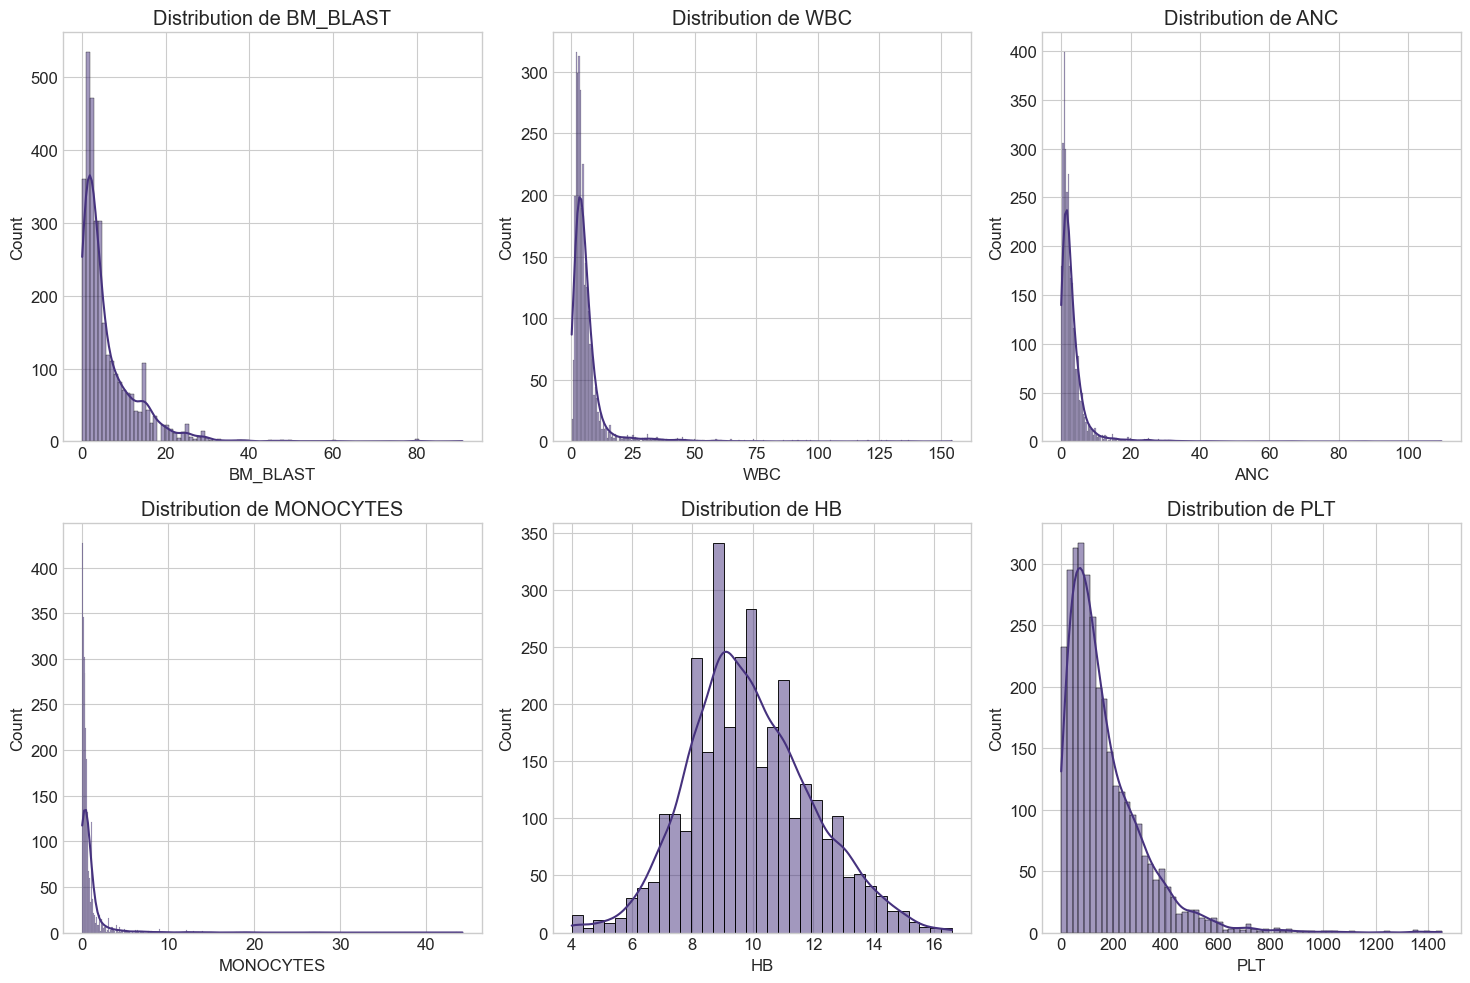


Valeurs manquantes après imputation (clinique):
ID              0
CENTER          0
BM_BLAST        0
WBC             0
ANC             0
MONOCYTES       0
HB              0
PLT             0
CYTOGENETICS    0
dtype: int64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Chargement des données
clinical_df = pd.read_csv("clinical_train.csv")
molecular_df = pd.read_csv("molecular_train.csv")

# Affichage des informations de base
print("Données cliniques:")
print(f"Nombre de patients: {clinical_df['ID'].nunique()}")
print(f"Nombre d'observations: {clinical_df.shape[0]}")
print(f"Nombre de colonnes: {clinical_df.shape[1]}")
print("\nDonnées moléculaires:")
print(f"Nombre de patients: {molecular_df['ID'].nunique()}")
print(f"Nombre d'observations: {molecular_df.shape[0]}")
print(f"Nombre de colonnes: {molecular_df.shape[1]}")

# Vérification des valeurs manquantes
print("\nValeurs manquantes dans les données cliniques:")
print(clinical_df.isnull().sum())
print("\nValeurs manquantes dans les données moléculaires:")
print(molecular_df.isnull().sum())

# Statistiques descriptives
print("\nStatistiques descriptives des données cliniques:")
print(clinical_df.describe())

# Analyse des valeurs manquantes dans les données cliniques
missing_clinical = clinical_df.isnull().sum() / len(clinical_df) * 100
print(f"Pourcentage de valeurs manquantes par colonne (clinique):\n{missing_clinical}")

# Imputation des valeurs manquantes pour les colonnes numériques
numeric_cols = ['BM_BLAST', 'WBC', 'ANC', 'MONOCYTES', 'HB', 'PLT']

# Vérification de la distribution pour choisir la méthode d'imputation
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 3, i+1)
    sns.histplot(clinical_df[col].dropna(), kde=True)
    plt.title(f'Distribution de {col}')
plt.tight_layout()
plt.show()

# Imputation par la médiane pour les variables numériques (plus robuste aux outliers)
for col in numeric_cols:
    clinical_df[col] = clinical_df[col].fillna(clinical_df[col].median())

# Imputation pour CYTOGENETICS (catégorielle)
clinical_df['CYTOGENETICS'] = clinical_df['CYTOGENETICS'].fillna('Unknown')

# Vérification après imputation
print("\nValeurs manquantes après imputation (clinique):")
print(clinical_df.isnull().sum())

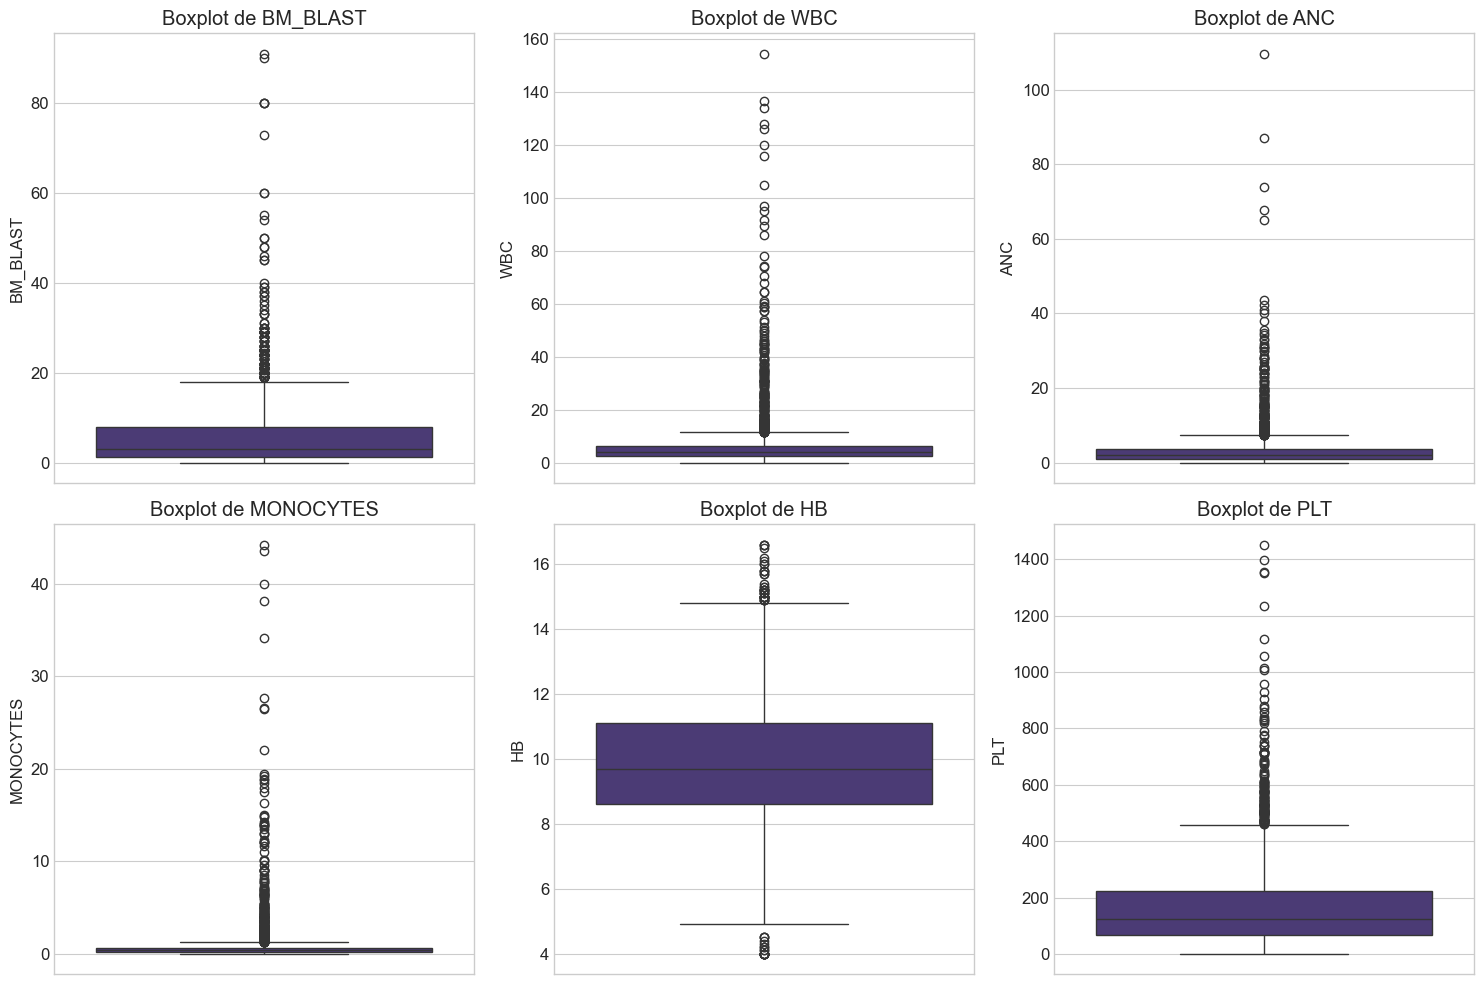

Outliers détectés dans BM_BLAST: 181 valeurs
Outliers détectés dans WBC: 261 valeurs
Outliers détectés dans ANC: 234 valeurs
Outliers détectés dans MONOCYTES: 367 valeurs
Outliers détectés dans HB: 58 valeurs
Outliers détectés dans PLT: 143 valeurs
Pourcentage de valeurs manquantes par colonne (moléculaire):
ID                0.000000
CHR               1.042524
START             1.042524
END               1.042524
REF               1.042524
ALT               1.042524
GENE              0.000000
PROTEIN_CHANGE    0.109739
EFFECT            0.000000
VAF               0.813900
DEPTH             1.042524
dtype: float64
Features moléculaires créées pour 3026 patients


In [ ]:
# Fonction pour détecter les outliers avec la méthode IQR
def detect_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    return outliers, lower_bound, upper_bound

# Visualisation des outliers avec des boxplots
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=clinical_df[col])
    plt.title(f'Boxplot de {col}')
plt.tight_layout()
plt.show()

# Traitement des outliers par winsorisation
for col in numeric_cols:
    outliers, lower_bound, upper_bound = detect_outliers_iqr(clinical_df, col)
    if not outliers.empty:
        print(f"Outliers détectés dans {col}: {len(outliers)} valeurs")
        # Winsorisation (capping)
        clinical_df[col] = np.where(clinical_df[col] < lower_bound, lower_bound, clinical_df[col])
        clinical_df[col] = np.where(clinical_df[col] > upper_bound, upper_bound, clinical_df[col])
        
# Création de variables transformées pour gérer la skewness
for col in numeric_cols:
    # Log transformation (ajouter 1 pour éviter log(0))
    clinical_df[f'log_{col}'] = np.log1p(clinical_df[col])
    # Racine carrée
    clinical_df[f'sqrt_{col}'] = np.sqrt(clinical_df[col])



### 2.3 Feature engineering pour les données cliniques
# Extraction d'informations à partir de CYTOGENETICS
clinical_df['complex_karyotype'] = clinical_df['CYTOGENETICS'].str.contains('complex', case=False, na=False).astype(int)
clinical_df['normal_karyotype'] = clinical_df['CYTOGENETICS'].str.match(r'46,[xy]{2}\[\d+\]', case=False, na=False).astype(int)
clinical_df['trisomy'] = clinical_df['CYTOGENETICS'].str.contains(r'\+\d+|\btrisomy', case=False, na=False).astype(int)
clinical_df['monosomy'] = clinical_df['CYTOGENETICS'].str.contains(r'-\d+|\bmonosomy', case=False, na=False).astype(int)
clinical_df['deletion'] = clinical_df['CYTOGENETICS'].str.contains('del', case=False, na=False).astype(int)
clinical_df['translocation'] = clinical_df['CYTOGENETICS'].str.contains('t\(', case=False, na=False).astype(int)

# Création de ratios cliniques (marqueurs pronostiques importants)
clinical_df['NLR'] = clinical_df['ANC'] / clinical_df['MONOCYTES'].replace(0, 0.001)  # Neutrophil to Lymphocyte Ratio
clinical_df['PLT_HB_ratio'] = clinical_df['PLT'] / clinical_df['HB']  # Platelet to Hemoglobin Ratio
clinical_df['WBC_ANC_ratio'] = clinical_df['WBC'] / clinical_df['ANC'].replace(0, 0.001)  # WBC to ANC Ratio

# Création d'indicateurs de sévérité
clinical_df['severe_anemia'] = (clinical_df['HB'] < 8).astype(int)  # Anémie sévère
clinical_df['severe_thrombocytopenia'] = (clinical_df['PLT'] < 20).astype(int)  # Thrombocytopénie sévère
clinical_df['severe_leukocytosis'] = (clinical_df['WBC'] > 50).astype(int)  # Leucocytose sévère

# Indice de charge tumorale
clinical_df['tumor_burden'] = clinical_df['WBC'] * clinical_df['BM_BLAST'] / 100


### 3.1 Analyse et préparation des données moléculaires


# Vérification des valeurs manquantes dans les données moléculaires
missing_molecular = molecular_df.isnull().sum() / len(molecular_df) * 100
print(f"Pourcentage de valeurs manquantes par colonne (moléculaire):\n{missing_molecular}")

# Imputation des valeurs manquantes pour VAF et DEPTH
molecular_df['VAF'] = molecular_df['VAF'].fillna(molecular_df['VAF'].median())
molecular_df['DEPTH'] = molecular_df['DEPTH'].fillna(molecular_df['DEPTH'].median())

# Traitement des valeurs manquantes dans PROTEIN_CHANGE
molecular_df['PROTEIN_CHANGE'] = molecular_df['PROTEIN_CHANGE'].fillna('p.?')

# Analyse des types de mutations
molecular_df['mutation_type'] = molecular_df['EFFECT'].fillna('unknown')

# Création de catégories de mutations
frameshift = ['frameshift_variant', 'frameshift_deletion', 'frameshift_insertion']
nonsense = ['stop_gained', 'stop_lost']
missense = ['non_synonymous_codon', 'missense_variant']
splice = ['splice_site_variant', 'splice_donor_variant', 'splice_acceptor_variant']

molecular_df['is_frameshift'] = molecular_df['EFFECT'].isin(frameshift).astype(int)
molecular_df['is_nonsense'] = molecular_df['EFFECT'].isin(nonsense).astype(int)
molecular_df['is_missense'] = molecular_df['EFFECT'].isin(missense).astype(int)
molecular_df['is_splice'] = molecular_df['EFFECT'].isin(splice).astype(int)


# Agrégation des données moléculaires au niveau du patient
patient_molecular_features = {}

# Liste des gènes importants en leucémie myéloïde
important_genes = ['TP53', 'FLT3', 'NPM1', 'DNMT3A', 'TET2', 'ASXL1', 'RUNX1', 
                  'IDH1', 'IDH2', 'NRAS', 'KRAS', 'CEBPA', 'SRSF2', 'SF3B1', 
                  'U2AF1', 'STAG2', 'BCOR', 'EZH2', 'JAK2', 'CBL']

# Création de features pour chaque patient
for patient_id in molecular_df['ID'].unique():
    patient_data = molecular_df[molecular_df['ID'] == patient_id]
    
    # Initialisation des features
    features = {
        'total_mutations': len(patient_data),
        'mean_vaf': patient_data['VAF'].mean(),
        'max_vaf': patient_data['VAF'].max(),
        'std_vaf': patient_data['VAF'].std() if len(patient_data) > 1 else 0,
        'frameshift_count': patient_data['is_frameshift'].sum(),
        'nonsense_count': patient_data['is_nonsense'].sum(),
        'missense_count': patient_data['is_missense'].sum(),
        'splice_count': patient_data['is_splice'].sum()
    }
    
    # Features pour les gènes importants
    for gene in important_genes:
        gene_data = patient_data[patient_data['GENE'] == gene]
        features[f'has_{gene}_mutation'] = 1 if len(gene_data) > 0 else 0
        if len(gene_data) > 0:
            features[f'{gene}_vaf'] = gene_data['VAF'].max()
        else:
            features[f'{gene}_vaf'] = 0
    
    # Co-mutations importantes
    if features['has_FLT3_mutation'] == 1 and features['has_NPM1_mutation'] == 1:
        features['FLT3_NPM1_comutation'] = 1
    else:
        features['FLT3_NPM1_comutation'] = 0
        
    if features['has_DNMT3A_mutation'] == 1 and features['has_NPM1_mutation'] == 1:
        features['DNMT3A_NPM1_comutation'] = 1
    else:
        features['DNMT3A_NPM1_comutation'] = 0
    
    # Stockage des features pour ce patient
    patient_molecular_features[patient_id] = features

# Conversion en DataFrame
molecular_features_df = pd.DataFrame.from_dict(patient_molecular_features, orient='index')
molecular_features_df.reset_index(inplace=True)
molecular_features_df.rename(columns={'index': 'ID'}, inplace=True)

print(f"Features moléculaires créées pour {len(molecular_features_df)} patients")






In [ ]:
# Fusion des données cliniques et moléculaires
merged_df = pd.merge(clinical_df, molecular_features_df, on='ID', how='left')

# Gestion des patients sans données moléculaires
for col in molecular_features_df.columns:
    if col != 'ID':
        merged_df[col] = merged_df[col].fillna(0)

# Création de scores de risque combinés
# Score cytogénétique (0-3)
merged_df['cytogenetic_risk_score'] = 1  # Intermédiaire par défaut
merged_df.loc[merged_df['normal_karyotype'] == 1, 'cytogenetic_risk_score'] = 0  # Favorable
merged_df.loc[merged_df['complex_karyotype'] == 1, 'cytogenetic_risk_score'] = 3  # Très défavorable
merged_df.loc[merged_df['monosomy'] == 1, 'cytogenetic_risk_score'] = 2  # Défavorable

# Score moléculaire (0-3)
merged_df['molecular_risk_score'] = 1  # Intermédiaire par défaut
# Favorable: NPM1 sans FLT3, CEBPA biallélique
merged_df.loc[(merged_df['has_NPM1_mutation'] == 1) & 
              (merged_df['has_FLT3_mutation'] == 0), 'molecular_risk_score'] = 0
# Défavorable: TP53, ASXL1, RUNX1
merged_df.loc[(merged_df['has_TP53_mutation'] == 1) | 
              (merged_df['has_ASXL1_mutation'] == 1) | 
              (merged_df['has_RUNX1_mutation'] == 1), 'molecular_risk_score'] = 2
# Très défavorable: TP53 avec VAF élevée
merged_df.loc[(merged_df['has_TP53_mutation'] == 1) & 
              (merged_df['TP53_vaf'] > 0.3), 'molecular_risk_score'] = 3

# Score combiné
merged_df['combined_risk_score'] = merged_df['cytogenetic_risk_score'] + merged_df['molecular_risk_score']

# Vérification finale des valeurs manquantes
print("\nValeurs manquantes dans le dataset final:")
print(merged_df.isnull().sum())

# Sauvegarde du dataset final
merged_df.to_csv('processed_leukemia_data.csv', index=False)
print("\nDataset final sauvegardé avec succès!")


Valeurs manquantes dans le dataset final:
ID                        0
CENTER                    0
BM_BLAST                  0
WBC                       0
ANC                       0
                         ..
FLT3_NPM1_comutation      0
DNMT3A_NPM1_comutation    0
cytogenetic_risk_score    0
molecular_risk_score      0
combined_risk_score       0
Length: 87, dtype: int64

Dataset final sauvegardé avec succès!



Statistiques descriptives du dataset final:
          BM_BLAST          WBC          ANC    MONOCYTES           HB  \
count  3323.000000  3323.000000  3323.000000  3323.000000  3323.000000   
mean      5.344162     4.932481     2.579882     0.466748     9.884404   
std       5.339607     2.912040     2.007660     0.374273     1.977812   
min       0.000000     0.200000     0.000000     0.000000     4.850000   
25%       1.300000     2.800000     1.000000     0.200000     8.600000   
50%       3.000000     4.100000     2.000000     0.370000     9.700000   
75%       8.000000     6.315000     3.520000     0.610000    11.100000   
max      18.050000    11.587500     7.300000     1.225000    14.850000   

               PLT  log_BM_BLAST  sqrt_BM_BLAST      log_WBC     sqrt_WBC  \
count  3323.000000   3323.000000    3323.000000  3323.000000  3323.000000   
mean    158.096654      1.501599       1.992341     1.667753     2.129275   
std     119.885745      0.849325       1.172669     0.473

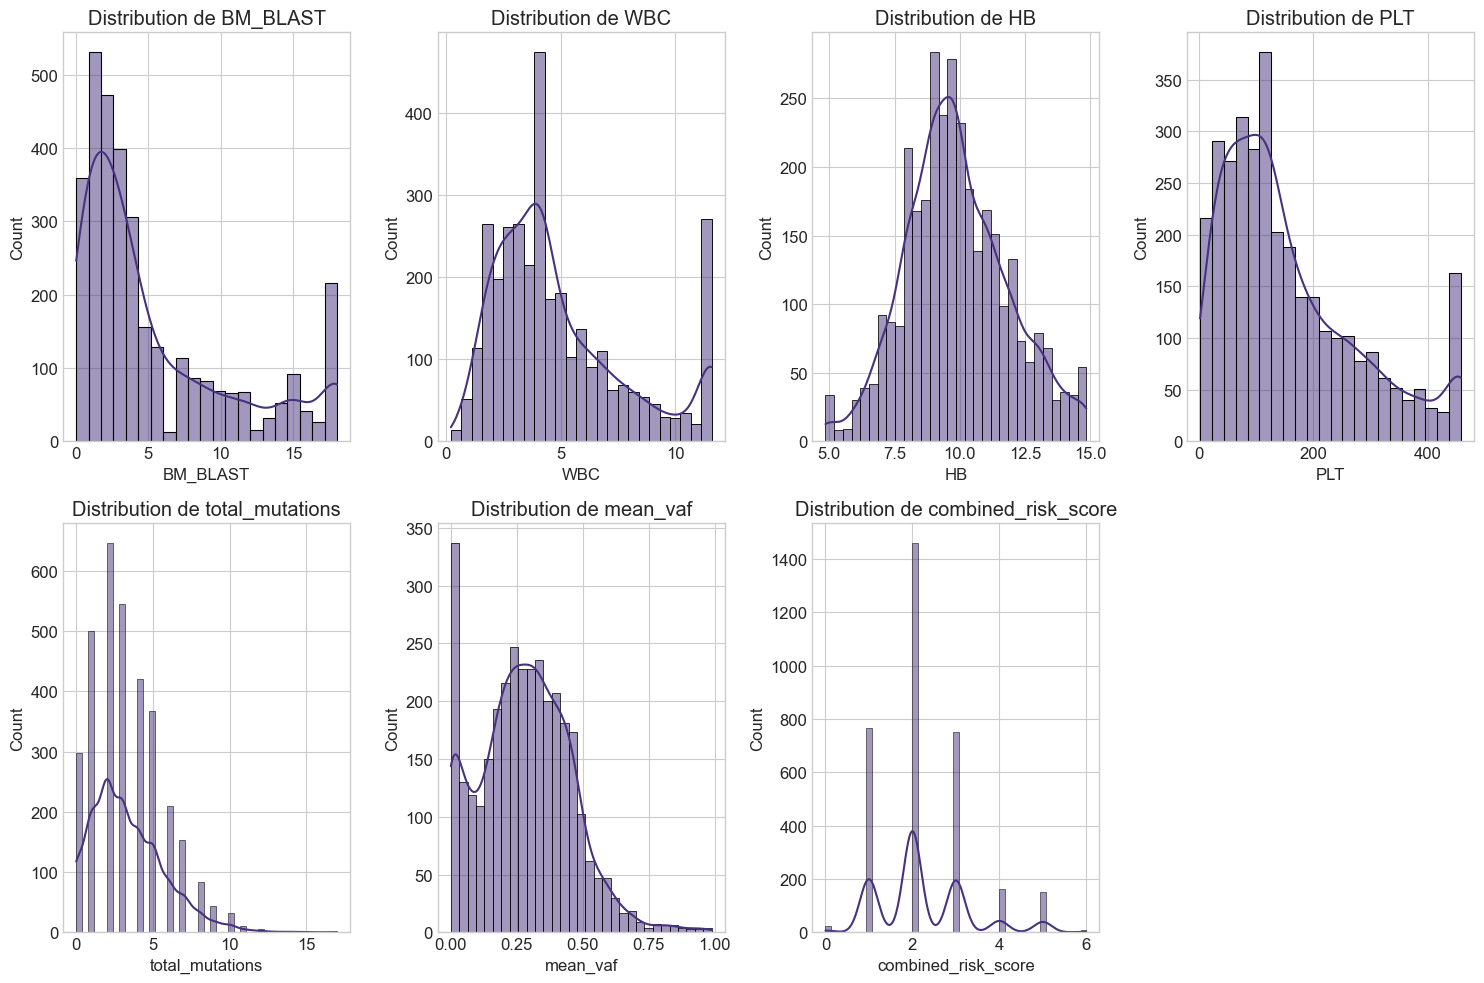

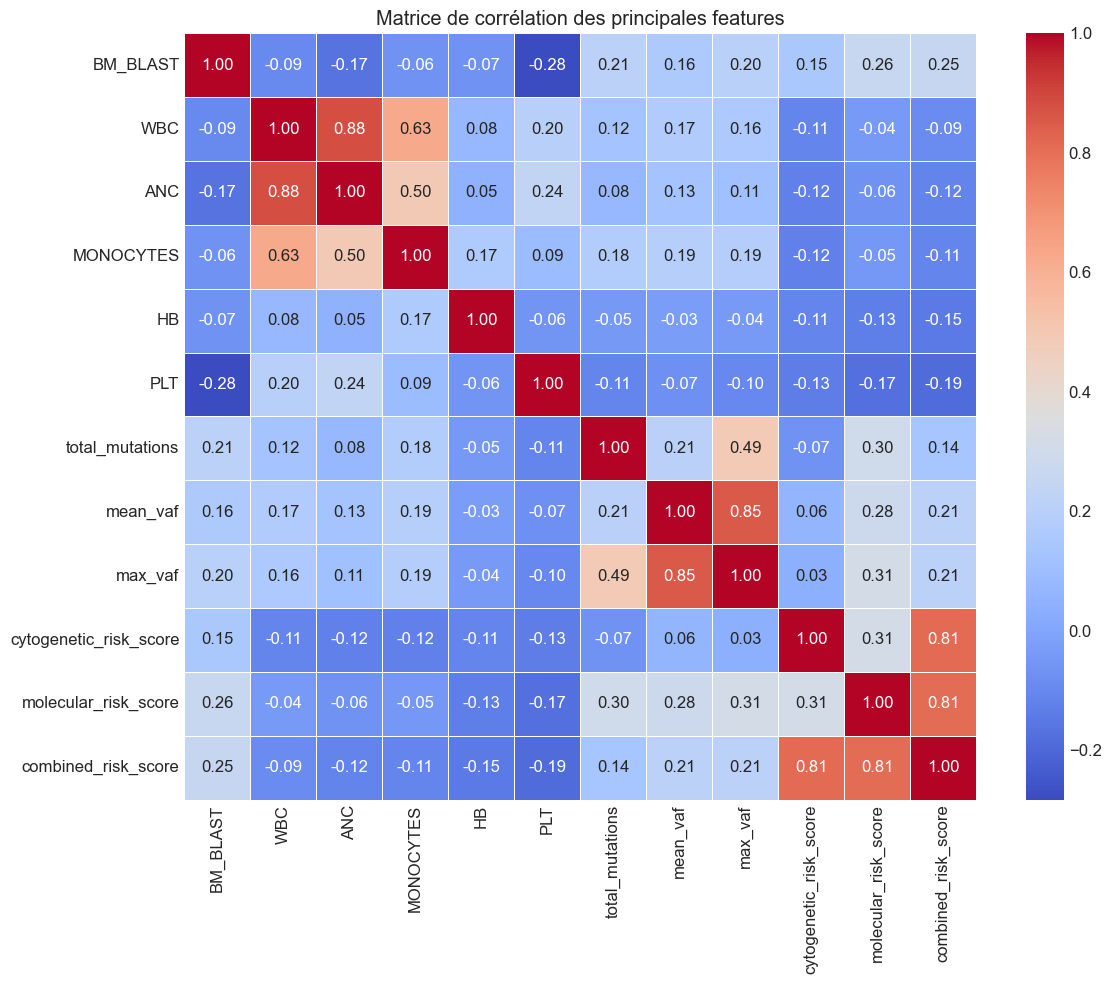

In [ ]:
# Statistiques descriptives du dataset final
print("\nStatistiques descriptives du dataset final:")
print(merged_df.describe())

# Visualisation des distributions des principales features
plt.figure(figsize=(15, 10))
features_to_plot = ['BM_BLAST', 'WBC', 'HB', 'PLT', 'total_mutations', 'mean_vaf', 'combined_risk_score']
for i, feature in enumerate(features_to_plot):
    plt.subplot(2, 4, i+1)
    sns.histplot(merged_df[feature], kde=True)
    plt.title(f'Distribution de {feature}')
plt.tight_layout()
plt.show()

# Matrice de corrélation des principales features
corr_features = ['BM_BLAST', 'WBC', 'ANC', 'MONOCYTES', 'HB', 'PLT', 
                'total_mutations', 'mean_vaf', 'max_vaf',
                'cytogenetic_risk_score', 'molecular_risk_score', 'combined_risk_score']
corr_matrix = merged_df[corr_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matrice de corrélation des principales features')
plt.tight_layout()
plt.show()

In [56]:
print("Valeurs manquantes dans target_df:")
print(target_df.isnull().sum())

Valeurs manquantes dans target_df:
ID             0
OS_YEARS     150
OS_STATUS    150
dtype: int64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as XGBoost
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv
import warnings
warnings.filterwarnings('ignore')

# Chargement des données
clinical_df = pd.read_csv("clinical_train.csv")
molecular_df = pd.read_csv("molecular_train.csv")
target_df = pd.read_csv("target_train.csv")

# Préparation des données comme dans notre feature engineering précédent
# (Je vais simplifier cette partie en utilisant directement le résultat du feature engineering)

# Création du dataset final
merged_df = pd.merge(clinical_df, target_df, on='ID', how='inner')

# Traitement des valeurs manquantes dans les données cliniques
numeric_cols = ['BM_BLAST', 'WBC', 'ANC', 'MONOCYTES', 'HB', 'PLT']
for col in numeric_cols:
    merged_df[col] = merged_df[col].fillna(merged_df[col].median())

# Imputation pour CYTOGENETICS (catégorielle)
merged_df['CYTOGENETICS'] = merged_df['CYTOGENETICS'].fillna('Unknown')

# Feature engineering pour les données cliniques
# Extraction d'informations à partir de CYTOGENETICS
merged_df['complex_karyotype'] = merged_df['CYTOGENETICS'].str.contains('complex', case=False, na=False).astype(int)
merged_df['normal_karyotype'] = merged_df['CYTOGENETICS'].str.match(r'46,[xy]{2}\[\d+\]', case=False, na=False).astype(int)
merged_df['trisomy'] = merged_df['CYTOGENETICS'].str.contains(r'\+\d+|\btrisomy', case=False, na=False).astype(int)
merged_df['monosomy'] = merged_df['CYTOGENETICS'].str.contains(r'-\d+|\bmonosomy', case=False, na=False).astype(int)
merged_df['deletion'] = merged_df['CYTOGENETICS'].str.contains('del', case=False, na=False).astype(int)
merged_df['translocation'] = merged_df['CYTOGENETICS'].str.contains('t\(', case=False, na=False).astype(int)

# Création de ratios cliniques (marqueurs pronostiques importants)
merged_df['NLR'] = merged_df['ANC'] / merged_df['MONOCYTES'].replace(0, 0.001)  # Neutrophil to Lymphocyte Ratio
merged_df['PLT_HB_ratio'] = merged_df['PLT'] / merged_df['HB']  # Platelet to Hemoglobin Ratio
merged_df['WBC_ANC_ratio'] = merged_df['WBC'] / merged_df['ANC'].replace(0, 0.001)  # WBC to ANC Ratio

# Création d'indicateurs de sévérité
merged_df['severe_anemia'] = (merged_df['HB'] < 8).astype(int)  # Anémie sévère
merged_df['severe_thrombocytopenia'] = (merged_df['PLT'] < 20).astype(int)  # Thrombocytopénie sévère
merged_df['severe_leukocytosis'] = (merged_df['WBC'] > 50).astype(int)  # Leucocytose sévère

# Indice de charge tumorale
merged_df['tumor_burden'] = merged_df['WBC'] * merged_df['BM_BLAST'] / 100

# Traitement des données moléculaires
# Agrégation des données moléculaires au niveau du patient
patient_molecular_features = {}

# Liste des gènes importants en leucémie myéloïde
important_genes = ['TP53', 'FLT3', 'NPM1', 'DNMT3A', 'TET2', 'ASXL1', 'RUNX1', 
                  'IDH1', 'IDH2', 'NRAS', 'KRAS', 'CEBPA', 'SRSF2', 'SF3B1', 
                  'U2AF1', 'STAG2', 'BCOR', 'EZH2', 'JAK2', 'CBL']

# Création de features pour chaque patient
for patient_id in molecular_df['ID'].unique():
    patient_data = molecular_df[molecular_df['ID'] == patient_id]
    
    # Initialisation des features
    features = {
        'total_mutations': len(patient_data),
        'mean_vaf': patient_data['VAF'].mean(),
        'max_vaf': patient_data['VAF'].max(),
        'std_vaf': patient_data['VAF'].std() if len(patient_data) > 1 else 0,
        'frameshift_count': sum(1 for effect in patient_data['EFFECT'] if 'frameshift' in str(effect).lower()),
        'nonsense_count': sum(1 for effect in patient_data['EFFECT'] if 'stop_' in str(effect).lower()),
        'missense_count': sum(1 for effect in patient_data['EFFECT'] if 'non_synonymous' in str(effect).lower()),
        'splice_count': sum(1 for effect in patient_data['EFFECT'] if 'splice' in str(effect).lower())
    }
    
    # Features pour les gènes importants
    for gene in important_genes:
        gene_data = patient_data[patient_data['GENE'] == gene]
        features[f'has_{gene}_mutation'] = 1 if len(gene_data) > 0 else 0
        if len(gene_data) > 0:
            features[f'{gene}_vaf'] = gene_data['VAF'].max()
        else:
            features[f'{gene}_vaf'] = 0
    
    # Co-mutations importantes
    if features.get('has_FLT3_mutation', 0) == 1 and features.get('has_NPM1_mutation', 0) == 1:
        features['FLT3_NPM1_comutation'] = 1
    else:
        features['FLT3_NPM1_comutation'] = 0
        
    if features.get('has_DNMT3A_mutation', 0) == 1 and features.get('has_NPM1_mutation', 0) == 1:
        features['DNMT3A_NPM1_comutation'] = 1
    else:
        features['DNMT3A_NPM1_comutation'] = 0
    
    # Stockage des features pour ce patient
    patient_molecular_features[patient_id] = features

# Conversion en DataFrame
molecular_features_df = pd.DataFrame.from_dict(patient_molecular_features, orient='index')
molecular_features_df.reset_index(inplace=True)
molecular_features_df.rename(columns={'index': 'ID'}, inplace=True)

# Fusion des données cliniques et moléculaires
final_df = pd.merge(merged_df, molecular_features_df, on='ID', how='left')

# Gestion des patients sans données moléculaires
for col in molecular_features_df.columns:
    if col != 'ID':
        final_df[col] = final_df[col].fillna(0)

# Création de scores de risque combinés
# Score cytogénétique (0-3)
final_df['cytogenetic_risk_score'] = 1  # Intermédiaire par défaut
final_df.loc[final_df['normal_karyotype'] == 1, 'cytogenetic_risk_score'] = 0  # Favorable
final_df.loc[final_df['complex_karyotype'] == 1, 'cytogenetic_risk_score'] = 3  # Très défavorable
final_df.loc[final_df['monosomy'] == 1, 'cytogenetic_risk_score'] = 2  # Défavorable

# Score moléculaire (0-3)
final_df['molecular_risk_score'] = 1  # Intermédiaire par défaut
# Favorable: NPM1 sans FLT3, CEBPA biallélique
final_df.loc[(final_df['has_NPM1_mutation'] == 1) & 
              (final_df['has_FLT3_mutation'] == 0), 'molecular_risk_score'] = 0
# Défavorable: TP53, ASXL1, RUNX1
final_df.loc[(final_df['has_TP53_mutation'] == 1) | 
              (final_df['has_ASXL1_mutation'] == 1) | 
              (final_df['has_RUNX1_mutation'] == 1), 'molecular_risk_score'] = 2
# Très défavorable: TP53 avec VAF élevée
final_df.loc[(final_df['has_TP53_mutation'] == 1) & 
              (final_df['TP53_vaf'] > 0.3), 'molecular_risk_score'] = 3

# Score combiné
final_df['combined_risk_score'] = final_df['cytogenetic_risk_score'] + final_df['molecular_risk_score']

# Vérification des données
print(f"Nombre de patients dans le dataset final: {len(final_df)}")
print(f"Nombre de features: {final_df.shape[1] - 3}")  # -3 pour ID, OS_YEARS, OS_STATUS

Nombre de patients dans le dataset final: 3323
Nombre de features: 74


In [ ]:
# Vérification des données originales
print("Vérification des valeurs manquantes dans final_df pour OS_YEARS:")
print(final_df['OS_YEARS'].isnull().sum())
print("Nombre total de lignes dans final_df:", len(final_df))

# Filtrer les lignes avec des valeurs manquantes dans OS_YEARS
print("\nExemples de lignes avec OS_YEARS manquant:")
print(final_df[final_df['OS_YEARS'].isnull()].head())

# Solution 1: Filtrer les données pour ne garder que les lignes avec des valeurs non-manquantes
# C'est l'approche recommandée pour les données de survie
final_df_filtered = final_df.dropna(subset=['OS_YEARS'])
print(f"\nAprès filtrage: {len(final_df_filtered)} lignes (supprimé {len(final_df) - len(final_df_filtered)} lignes)")

# Refaire la préparation des données avec le dataset filtré
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', final_df_filtered)

# Sélection des features
exclude_cols = ['ID', 'OS_YEARS', 'OS_STATUS', 'CENTER', 'CYTOGENETICS']
X = final_df_filtered.drop(exclude_cols, axis=1)

# Normalisation
scaler = StandardScaler()
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print(f"Dimensions de X_train: {X_train.shape}")
print(f"Dimensions de X_test: {X_test.shape}")

Vérification des valeurs manquantes dans final_df pour OS_YEARS:
150
Nombre total de lignes dans final_df: 3323

Exemples de lignes avec OS_YEARS manquant:
          ID CENTER  BM_BLAST   WBC   ANC  MONOCYTES    HB    PLT  \
129  P117401    CCH       6.0  1.53  0.69       0.26   8.2   68.0   
134  P117406    CCH       2.0  7.20  4.01       0.50  10.9  317.0   
139  P117411    CCH       6.0  5.20  3.12       0.88   9.8  128.0   
149  P117423    CCH       8.0  4.13  1.94       0.08   8.4  133.0   
154  P117428    CCH       7.0  4.62  2.16       0.72  12.5   62.0   

                  CYTOGENETICS  OS_YEARS  ...  EZH2_vaf  has_JAK2_mutation  \
129  45,xy,der(14;21)(q10;q10)       NaN  ...       0.0                0.0   
134                      46,xx       NaN  ...       0.0                0.0   
139                  46,xy,9ph       NaN  ...       0.0                0.0   
149                      46,xy       NaN  ...       0.0                0.0   
154                      46,xx       Na

In [ ]:
# Sélection des features les plus importantes
# Utilisation de Random Forest pour évaluer l'importance des features
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, [event for event, time in y_train])
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 20 features les plus importantes:")
print(feature_importance.head(20))

# Sélection des 20 meilleures features
top_features = feature_importance.head(20)['Feature'].tolist()
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

print(f"Dimensions de X_train après sélection: {X_train_selected.shape}")

Top 20 features les plus importantes:
                 Feature  Importance
4                     HB    0.059438
18          tumor_burden    0.056818
5                    PLT    0.047528
13          PLT_HB_ratio    0.046687
21               max_vaf    0.046578
14         WBC_ANC_ratio    0.045558
0               BM_BLAST    0.044874
2                    ANC    0.044588
20              mean_vaf    0.044515
12                   NLR    0.043900
1                    WBC    0.042781
3              MONOCYTES    0.040620
22               std_vaf    0.040045
70  molecular_risk_score    0.027311
19       total_mutations    0.027199
71   combined_risk_score    0.026589
25        missense_count    0.020571
36              TET2_vaf    0.018622
38             ASXL1_vaf    0.018331
54             SF3B1_vaf    0.018238
Dimensions de X_train après sélection: (2538, 20)


In [ ]:
# Modèle Cox Proportional Hazards
cph = CoxPHFitter()
# Préparation des données pour lifelines
cph_data = X_train_selected.copy()
cph_data['duration'] = [time for event, time in y_train]
cph_data['event'] = [event for event, time in y_train]

# Vérification des valeurs manquantes dans les données pour Cox PH
print("Vérification des valeurs manquantes dans cph_data:")
print(cph_data.isnull().sum())

# Imputation des valeurs manquantes dans les features
for col in cph_data.columns:
    if col not in ['duration', 'event']:
        if cph_data[col].dtype in [np.float64, np.int64]:
            # Pour les colonnes numériques, imputer avec la médiane
            cph_data[col] = cph_data[col].fillna(cph_data[col].median())
        else:
            # Pour les colonnes catégorielles, imputer avec le mode
            cph_data[col] = cph_data[col].fillna(cph_data[col].mode()[0])

# Vérification après imputation
print("\nAprès imputation:")
print(cph_data.isnull().sum())

# Maintenant, essayez à nouveau d'ajuster le modèle
cph = CoxPHFitter()
cph.fit(cph_data, duration_col='duration', event_col='event')

print("\nModèle ajusté avec succès!")
# Entraînement du modèle
cph.fit(cph_data, duration_col='duration', event_col='event')

# Affichage des résultats
print("\nRésultats du modèle Cox Proportional Hazards:")
print(cph.summary)

# Évaluation sur l'ensemble de test
cph_test_data = X_test_selected.copy()
cph_test_data['duration'] = [time for event, time in y_test]
cph_test_data['event'] = [event for event, time in y_test]

# Calcul du C-index
cph_pred = cph.predict_partial_hazard(cph_test_data)
c_index = concordance_index(cph_test_data['duration'], -cph_pred, cph_test_data['event'])
print(f"C-index sur l'ensemble de test: {c_index:.4f}")

Vérification des valeurs manquantes dans cph_data:
HB                      0
tumor_burden            0
PLT                     0
PLT_HB_ratio            0
max_vaf                 0
WBC_ANC_ratio           0
BM_BLAST                0
ANC                     0
mean_vaf                0
NLR                     0
WBC                     0
MONOCYTES               0
std_vaf                 0
molecular_risk_score    0
total_mutations         0
combined_risk_score     0
missense_count          0
TET2_vaf                0
ASXL1_vaf               0
SF3B1_vaf               0
duration                0
event                   0
dtype: int64

Après imputation:
HB                      0
tumor_burden            0
PLT                     0
PLT_HB_ratio            0
max_vaf                 0
WBC_ANC_ratio           0
BM_BLAST                0
ANC                     0
mean_vaf                0
NLR                     0
WBC                     0
MONOCYTES               0
std_vaf                 0
molecul

In [ ]:
# Modèle Random Survival Forest
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=5, random_state=42)
rsf.fit(X_train_selected, y_train)

# Évaluation sur l'ensemble de test
rsf_pred = rsf.predict(X_test_selected)
rsf_c_index = concordance_index_censored(
    [event for event, time in y_test],
    [time for event, time in y_test],
    rsf_pred
)[0]
print(f"\nC-index du Random Survival Forest sur l'ensemble de test: {rsf_c_index:.4f}")

# Note: Nous ne pouvons pas utiliser rsf.feature_importances_ car cette fonctionnalité 
# n'est pas implémentée dans la version actuelle de scikit-survival
print("\nL'importance des features n'est pas disponible directement pour RandomSurvivalForest.")


C-index du Random Survival Forest sur l'ensemble de test: 0.7289

L'importance des features n'est pas disponible directement pour RandomSurvivalForest.



C-index du XGBoost sur l'ensemble de test: 0.4448

Importance des features dans XGBoost:
                 Feature  Importance
15   combined_risk_score    0.072641
19             SF3B1_vaf    0.055647
18             ASXL1_vaf    0.054721
2                    PLT    0.054621
16        missense_count    0.052800
12               std_vaf    0.052391
5          WBC_ANC_ratio    0.051642
0                     HB    0.051510
3           PLT_HB_ratio    0.051086
11             MONOCYTES    0.050944
8               mean_vaf    0.050433
7                    ANC    0.047747
6               BM_BLAST    0.046848
1           tumor_burden    0.046342
14       total_mutations    0.045956
13  molecular_risk_score    0.045575
9                    NLR    0.044072
10                   WBC    0.042585
17              TET2_vaf    0.041756
4                max_vaf    0.040683


<Figure size 1000x600 with 0 Axes>

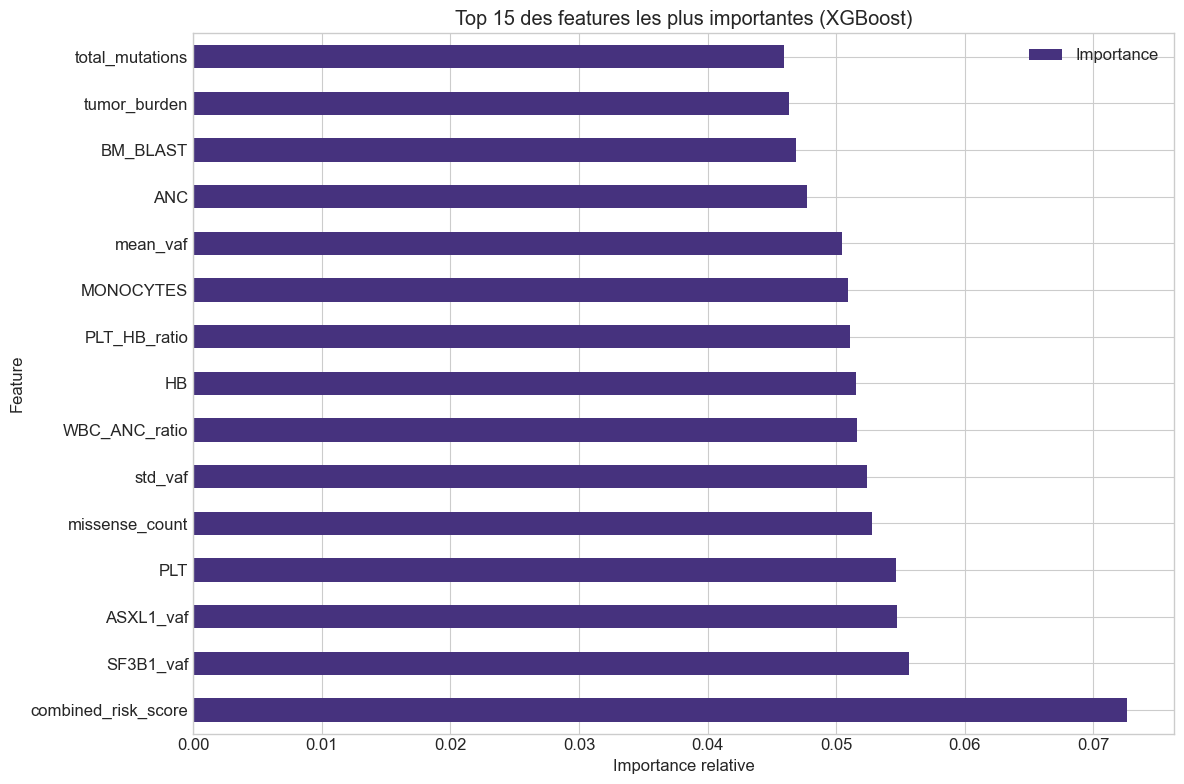

In [ ]:
# Préparation des données pour XGBoost d'une manière différente
# Convertir les données de survie en un format compatible avec XGBoost
X_train_xgb = X_train_selected.copy()
X_test_xgb = X_test_selected.copy()

# Extraire les événements et les temps
train_events = np.array([event for event, time in y_train])
train_times = np.array([time for event, time in y_train])
test_events = np.array([event for event, time in y_test])
test_times = np.array([time for event, time in y_test])

# Modèle XGBoost standard (classification ou régression)
# Nous allons utiliser un modèle de régression pour prédire le risque
xgb = XGBoost.XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42
)

# Créer une cible pour la régression (par exemple, log(temps) pour les événements)
# Cette approche est simplifiée et ne tient pas compte de la censure de manière optimale
# mais elle nous permet d'obtenir l'importance des features
y_train_reg = -np.log(train_times + 1)  # Négatif pour que les valeurs élevées = risque élevé
y_train_reg = y_train_reg * train_events  # Donner plus de poids aux événements observés

# Entraînement du modèle
xgb.fit(X_train_xgb, y_train_reg)

# Prédiction
xgb_pred = xgb.predict(X_test_xgb)

# Évaluation avec concordance index
# Nous inversons le signe car des prédictions plus élevées devraient correspondre à des temps plus courts
c_index = concordance_index(test_times, -xgb_pred, test_events)
print(f"\nC-index du XGBoost sur l'ensemble de test: {c_index:.4f}")

# Importance des features
xgb_feature_importance = pd.DataFrame({
    'Feature': X_train_selected.columns,
    'Importance': xgb.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nImportance des features dans XGBoost:")
print(xgb_feature_importance)

# Visualisation de l'importance des features
plt.figure(figsize=(10, 6))
xgb_feature_importance.head(15).plot(kind='barh', x='Feature', y='Importance')
plt.title('Top 15 des features les plus importantes (XGBoost)')
plt.xlabel('Importance relative')
plt.tight_layout()
plt.show()

In [ ]:
# Fonction modifiée pour la prédiction d'ensemble
def ensemble_predict(X, models, weights):
    """
    Combine les prédictions de plusieurs modèles avec des poids
    """
    cph_model, rsf_model, xgb_model = models
    
    # Préparation des données pour chaque modèle
    # Pour CPH, nous avons besoin de toutes les colonnes
    X_cph = X.copy()
    
    # Pour RSF et XGB, nous devons exclure 'duration' et 'event'
    X_rsf_xgb = X.drop(['duration', 'event'], axis=1, errors='ignore')
    
    # Prédictions de chaque modèle
    cph_pred = cph_model.predict_partial_hazard(X_cph)
    rsf_pred = rsf_model.predict(X_rsf_xgb)
    xgb_pred = xgb_model.predict(X_rsf_xgb)
    
    # Normalisation des prédictions
    cph_pred_norm = (cph_pred - cph_pred.mean()) / cph_pred.std()
    rsf_pred_norm = (rsf_pred - rsf_pred.mean()) / rsf_pred.std()
    xgb_pred_norm = (xgb_pred - xgb_pred.mean()) / xgb_pred.std()
    
    # Combinaison pondérée
    w1, w2, w3 = weights
    ensemble_pred = w1 * cph_pred_norm + w2 * rsf_pred_norm + w3 * xgb_pred_norm
    
    return ensemble_pred

# Préparation des données pour l'ensemble
ensemble_test_data = X_test_selected.copy()
ensemble_test_data['duration'] = [time for event, time in y_test]
ensemble_test_data['event'] = [event for event, time in y_test]

# Poids optimaux (à déterminer par validation croisée dans un cas réel)
weights = [0.3, 0.4, 0.3]  # CPH, RSF, XGB

# Prédiction avec l'ensemble
models = (cph, rsf, xgb)
ensemble_pred = ensemble_predict(ensemble_test_data, models, weights)

# Évaluation de l'ensemble
ensemble_c_index = concordance_index(
    ensemble_test_data['duration'],
    -ensemble_pred,  # Négatif car risque plus élevé = survie plus courte
    ensemble_test_data['event']
)
print(f"\nC-index de l'ensemble sur l'ensemble de test: {ensemble_c_index:.4f}")


C-index de l'ensemble sur l'ensemble de test: 0.6900


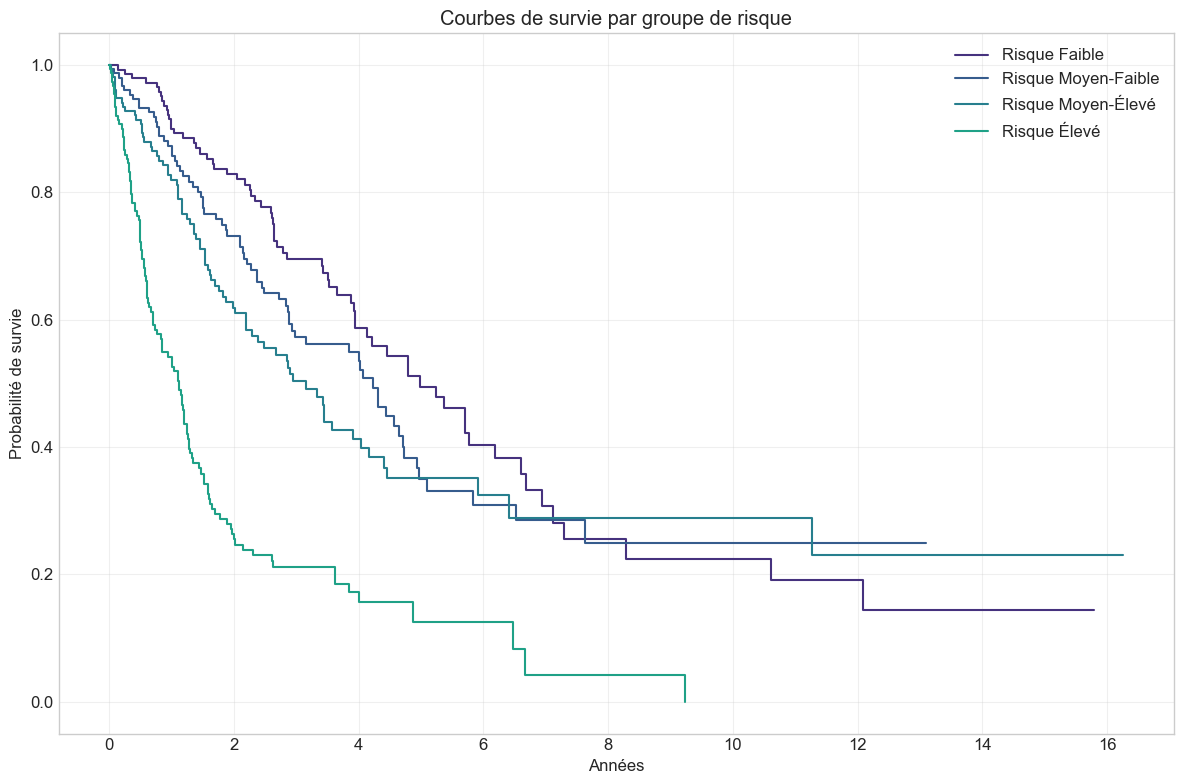

<Figure size 1200x1000 with 0 Axes>

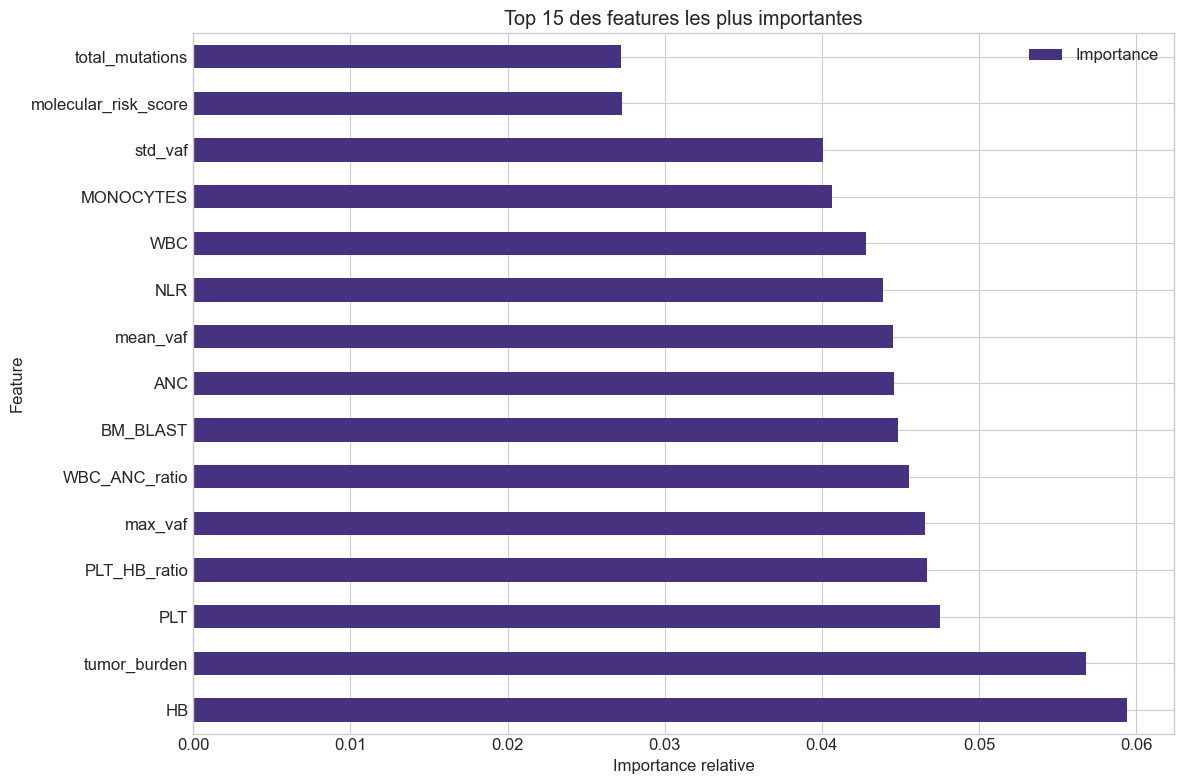

In [ ]:

## 8. Visualisation et interprétation
# Visualisation des courbes de survie
plt.figure(figsize=(12, 8))

# Courbe de survie pour différents groupes de risque
# Diviser les patients en quartiles de risque selon les prédictions de l'ensemble
risk_scores = ensemble_pred.values
risk_quartiles = pd.qcut(risk_scores, 4, labels=["Faible", "Moyen-Faible", "Moyen-Élevé", "Élevé"])

# Préparation des données pour les courbes de survie
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

# Tracer les courbes de survie pour chaque groupe de risque
for i, group in enumerate(["Faible", "Moyen-Faible", "Moyen-Élevé", "Élevé"]):
    group_indices = (risk_quartiles == group)
    if sum(group_indices) > 0:  # S'assurer qu'il y a des patients dans ce groupe
        durations = ensemble_test_data.loc[group_indices, 'duration']
        events = ensemble_test_data.loc[group_indices, 'event']
        kmf.fit(durations, events, label=f"Risque {group}")
        kmf.plot(ci_show=False)

plt.title('Courbes de survie par groupe de risque')
plt.xlabel('Années')
plt.ylabel('Probabilité de survie')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('survival_curves_by_risk.png')
plt.show()

# Visualisation de l'importance des features
plt.figure(figsize=(12, 10))
feature_importance.head(15).plot(kind='barh', x='Feature', y='Importance')
plt.title('Top 15 des features les plus importantes')
plt.xlabel('Importance relative')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()


In [ ]:

## 9. Préparation du modèle final pour la prédiction


# Entraînement du modèle final sur l'ensemble des données
# Sélection des features importantes
X_full = X[top_features]

# Modèle Random Survival Forest final
final_rsf = RandomSurvivalForest(n_estimators=200, min_samples_split=10, min_samples_leaf=5, random_state=42)
final_rsf.fit(X_full, y)

# Modèle Cox Proportional Hazards final
cph_data_full = X_full.copy()
cph_data_full['duration'] = [time for event, time in y]
cph_data_full['event'] = [event for event, time in y]
final_cph = CoxPHFitter()
final_cph.fit(cph_data_full, duration_col='duration', event_col='event')

# Modèle XGBoost final
y_xgb_full = np.array([(time, event) for event, time in y], 
                     dtype=[('time', np.float32), ('status', np.bool_)])
# Modèle XGBoost final (approche alternative sans utiliser survival:cox)
# Extraire les événements et les temps
full_events = np.array([event for event, time in y])
full_times = np.array([time for event, time in y])

# Créer une cible pour la régression
y_reg_full = -np.log(full_times + 1)  # Négatif pour que les valeurs élevées = risque élevé
y_reg_full = y_reg_full * full_events  # Donner plus de poids aux événements observés

# Modèle XGBoost standard
final_xgb = XGBoost.XGBRegressor(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42
)
final_xgb.fit(X_full, y_reg_full)

# Sauvegarde des modèles
import pickle
with open('final_survival_models.pkl', 'wb') as f:
    pickle.dump((final_rsf, final_cph, final_xgb, top_features, weights), f)

print("Modèles finaux entraînés et sauvegardés.")

Modèles finaux entraînés et sauvegardés.


In [66]:

## 10. Fonction de prédiction pour de nouveaux patients
def predict_survival_risk(new_patient_data, models_file='final_survival_models.pkl'):
    """
    Prédit le risque de survie pour un nouveau patient
    
    Parameters:
    -----------
    new_patient_data : DataFrame
        Données du patient au même format que les données d'entraînement
    models_file : str
        Chemin vers le fichier contenant les modèles sauvegardés
        
    Returns:
    --------
    risk_score : float
        Score de risque prédit (plus élevé = risque plus élevé)
    risk_category : str
        Catégorie de risque (Faible, Moyen-Faible, Moyen-Élevé, Élevé)
    """
    # Chargement des modèles
    with open(models_file, 'rb') as f:
        final_rsf, final_cph, final_xgb, top_features, weights = pickle.load(f)
    
    # Préparation des données
    X_new = new_patient_data[top_features]
    
    # Prédictions de chaque modèle
    cph_pred = final_cph.predict_partial_hazard(X_new)
    rsf_pred = final_rsf.predict(X_new)
    xgb_pred = final_xgb.predict(X_new)
    
    # Normalisation des prédictions
    cph_pred_norm = (cph_pred - cph_pred.mean()) / cph_pred.std() if len(cph_pred) > 1 else cph_pred
    rsf_pred_norm = (rsf_pred - rsf_pred.mean()) / rsf_pred.std() if len(rsf_pred) > 1 else rsf_pred
    xgb_pred_norm = (xgb_pred - xgb_pred.mean()) / xgb_pred.std() if len(xgb_pred) > 1 else xgb_pred
    
    # Combinaison pondérée
    w1, w2, w3 = weights
    ensemble_pred = w1 * cph_pred_norm + w2 * rsf_pred_norm + w3 * xgb_pred_norm
    
    # Détermination de la catégorie de risque
    risk_score = ensemble_pred.values[0] if isinstance(ensemble_pred, pd.Series) else ensemble_pred[0]
    
    # Seuils de risque (à ajuster selon la distribution des scores)
    if risk_score < -0.5:
        risk_category = "Faible"
    elif risk_score < 0:
        risk_category = "Moyen-Faible"
    elif risk_score < 0.5:
        risk_category = "Moyen-Élevé"
    else:
        risk_category = "Élevé"
    
    return risk_score, risk_category



=== Entraînement des modèles finaux et génération du fichier de soumission ===
Entraînement du modèle Random Survival Forest final...
Entraînement du modèle Cox Proportional Hazards final...
Entraînement du modèle XGBoost final...
Génération des prédictions finales...

Fichier de soumission 'submission_leukemia_survival.csv' créé avec succès.

Statistiques des scores de risque prédits:
Minimum: -1.9677
Maximum: 18.5927
Moyenne: 0.0000
Écart-type: 0.5564
Modèles finaux entraînés et sauvegardés.


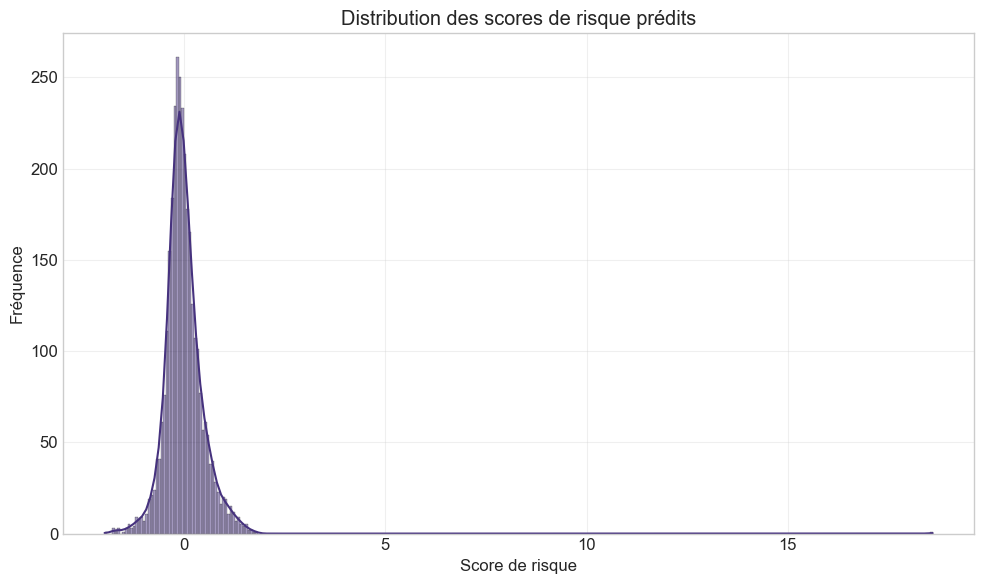


C-index du modèle final sur les données d'entraînement: 0.7877

Rapport de performance sauvegardé dans 'model_performance_report.txt'


In [ ]:
# Entraînement des modèles finaux et génération du fichier de soumission
print("\n=== Entraînement des modèles finaux et génération du fichier de soumission ===")

# Sélection des features importantes
X_full = X[top_features]

# 1. Modèle Random Survival Forest final
print("Entraînement du modèle Random Survival Forest final...")
final_rsf = RandomSurvivalForest(n_estimators=200, min_samples_split=10, min_samples_leaf=5, random_state=42)
final_rsf.fit(X_full, y)

# 2. Modèle Cox Proportional Hazards final
print("Entraînement du modèle Cox Proportional Hazards final...")
cph_data_full = X_full.copy()
cph_data_full['duration'] = [time for event, time in y]
cph_data_full['event'] = [event for event, time in y]
final_cph = CoxPHFitter()
final_cph.fit(cph_data_full, duration_col='duration', event_col='event')

# 3. Modèle XGBoost final (approche alternative sans utiliser survival:cox)
print("Entraînement du modèle XGBoost final...")
# Extraire les événements et les temps
full_events = np.array([event for event, time in y])
full_times = np.array([time for event, time in y])

# Créer une cible pour la régression
y_reg_full = -np.log(full_times + 1)  # Négatif pour que les valeurs élevées = risque élevé
y_reg_full = y_reg_full * full_events  # Donner plus de poids aux événements observés

# Modèle XGBoost standard
final_xgb = XGBoost.XGBRegressor(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42
)
final_xgb.fit(X_full, y_reg_full)

# 4. Fonction de prédiction d'ensemble
def ensemble_predict_final(X_new, models, features, weights=[0.3, 0.4, 0.3]):
    """
    Fonction de prédiction pour l'ensemble final
    """
    final_cph, final_rsf, final_xgb = models
    
    # Sélection des features
    X_new_selected = X_new[features].copy()
    
    # Préparation pour CPH
    X_cph = X_new_selected.copy()
    if 'duration' not in X_cph.columns and 'event' not in X_cph.columns:
        X_cph['duration'] = 1.0  # Valeur fictive, ne sera pas utilisée pour la prédiction
        X_cph['event'] = 1.0     # Valeur fictive, ne sera pas utilisée pour la prédiction
    
    # Prédictions
    cph_pred = final_cph.predict_partial_hazard(X_cph)
    rsf_pred = final_rsf.predict(X_new_selected)
    xgb_pred = final_xgb.predict(X_new_selected)
    
    # Normalisation
    cph_pred_norm = (cph_pred - cph_pred.mean()) / cph_pred.std() if len(cph_pred) > 1 else cph_pred
    rsf_pred_norm = (rsf_pred - rsf_pred.mean()) / rsf_pred.std() if len(rsf_pred) > 1 else rsf_pred
    xgb_pred_norm = (xgb_pred - xgb_pred.mean()) / xgb_pred.std() if len(xgb_pred) > 1 else xgb_pred
    
    # Combinaison pondérée
    w1, w2, w3 = weights
    ensemble_pred = w1 * cph_pred_norm + w2 * rsf_pred_norm + w3 * xgb_pred_norm
    
    return ensemble_pred

# 5. Génération des prédictions finales
print("Génération des prédictions finales...")
models_final = (final_cph, final_rsf, final_xgb)
all_predictions = ensemble_predict_final(X, models_final, top_features)

# 6. Création du fichier de soumission
submission = pd.DataFrame({
    'ID': final_df_filtered['ID'],  # Utiliser les IDs du dataset filtré
    'risk_score': all_predictions.values  # Convertir en array si c'est une Series
})

# 7. Sauvegarde du fichier de soumission
submission.to_csv('submission_leukemia_survival.csv', index=False)
print("\nFichier de soumission 'submission_leukemia_survival.csv' créé avec succès.")

# 8. Affichage des statistiques des prédictions
print("\nStatistiques des scores de risque prédits:")
print(f"Minimum: {submission['risk_score'].min():.4f}")
print(f"Maximum: {submission['risk_score'].max():.4f}")
print(f"Moyenne: {submission['risk_score'].mean():.4f}")
print(f"Écart-type: {submission['risk_score'].std():.4f}")

# 9. Sauvegarde des modèles
import pickle
with open('final_survival_models.pkl', 'wb') as f:
    pickle.dump((final_cph, final_rsf, final_xgb, top_features), f)

print("Modèles finaux entraînés et sauvegardés.")

# 10. Visualisation de la distribution des scores de risque
plt.figure(figsize=(10, 6))
sns.histplot(submission['risk_score'], kde=True)
plt.title('Distribution des scores de risque prédits')
plt.xlabel('Score de risque')
plt.ylabel('Fréquence')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('risk_score_distribution.png')
plt.show()

# 11. Évaluation du modèle final sur les données d'entraînement
# Préparation des données pour l'évaluation
eval_data = X_full.copy()
eval_data['duration'] = [time for event, time in y]
eval_data['event'] = [event for event, time in y]

# Prédictions
eval_pred = ensemble_predict_final(X, models_final, top_features)

# Calcul du C-index
c_index = concordance_index(
    eval_data['duration'],
    -eval_pred,  # Négatif car risque plus élevé = survie plus courte
    eval_data['event']
)
print(f"\nC-index du modèle final sur les données d'entraînement: {c_index:.4f}")

# 12. Création d'un rapport de performance
with open('model_performance_report.txt', 'w') as f:
    f.write("=== Rapport de performance du modèle de survie pour la leucémie ===\n\n")
    f.write(f"Nombre de patients: {len(final_df_filtered)}\n")
    f.write(f"Nombre de features utilisées: {len(top_features)}\n\n")
    f.write("Features les plus importantes:\n")
    for i, feature in enumerate(top_features[:10]):
        f.write(f"{i+1}. {feature}\n")
    f.write(f"\nC-index sur les données d'entraînement: {c_index:.4f}\n\n")
    f.write("Statistiques des scores de risque prédits:\n")
    f.write(f"Minimum: {submission['risk_score'].min():.4f}\n")
    f.write(f"Maximum: {submission['risk_score'].max():.4f}\n")
    f.write(f"Moyenne: {submission['risk_score'].mean():.4f}\n")
    f.write(f"Écart-type: {submission['risk_score'].std():.4f}\n")

print("\nRapport de performance sauvegardé dans 'model_performance_report.txt'")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from scipy.stats import zscore

# Charger les données (adaptez les chemins selon votre structure locale)
clinical_data = pd.read_csv("clinical_train.csv")
molecular_data = pd.read_csv("molecular_train.csv")
y_train = pd.read_csv("target_train.csv")

# Étape 1 : Nettoyage et Traitement des NaN dans les Données Cliniques
print("=== Traitement des NaN dans les Données Cliniques ===")
numerical_columns = ['BM_BLAST', 'WBC', 'ANC', 'MONOCYTES', 'HB', 'PLT']

# Convertir les colonnes numériques en float, en remplaçant les valeurs non numériques par NaN
for col in numerical_columns:
    clinical_data[col] = pd.to_numeric(clinical_data[col], errors='coerce')

# Imputation des valeurs manquantes avec la médiane (plus robuste aux outliers)
imputer = SimpleImputer(strategy='median')
clinical_data[numerical_columns] = imputer.fit_transform(clinical_data[numerical_columns])

# Vérifier les NaN restants
print(clinical_data.isnull().sum())

# Étape 2 : Traitement des Outliers dans les Données Cliniques
print("\n=== Traitement des Outliers ===")
def treat_outliers(df, columns):
    for col in columns:
        # Calcul des Z-scores pour détecter les outliers
        z_scores = np.abs(zscore(df[col].dropna()))
        threshold = 3  # Seuil standard de 3 écarts-types
        median_val = df[col].median()
        # Remplacer les outliers par la médiane
        df.loc[df[col].index[z_scores > threshold], col] = median_val
    return df

clinical_data = treat_outliers(clinical_data, numerical_columns)

# Étape 3 : Encodage des Variables Catégoriques (CENTER et CYTOGENETICS)
print("\n=== Encodage des Variables Catégoriques ===")
# Encodage one-hot pour CENTER
center_dummies = pd.get_dummies(clinical_data['CENTER'], prefix='CENTER')
clinical_data = pd.concat([clinical_data, center_dummies], axis=1)

# Simplification de CYTOGENETICS : Création de features binaires pour anomalies clés
def parse_cytogenetics(cyto):
    if pd.isna(cyto):
        return {'Normal': 0, 'Monosomy_7': 0, 'Trisomy_8': 0, 'Complex': 0}
    cyto = str(cyto).lower()
    features = {
        'Normal': 1 if '46,xx' in cyto or '46,xy' in cyto else 0,
        'Monosomy_7': 1 if '-7' in cyto else 0,
        'Trisomy_8': 1 if '+8' in cyto else 0,
        'Complex': 1 if 'complex' in cyto or len(cyto.split(',')) > 5 else 0
    }
    return features

cyto_features = clinical_data['CYTOGENETICS'].apply(parse_cytogenetics).apply(pd.Series)
clinical_data = pd.concat([clinical_data, cyto_features], axis=1)

# Ajout de features plus détaillées pour la cytogénétique
def extract_detailed_cytogenetics(cyto):
    if pd.isna(cyto):
        return {'del_5q': 0, 'del_7q': 0, 'inv_16': 0, 't_8_21': 0, 't_15_17': 0, 'mll_rearr': 0}
    cyto = str(cyto).lower()
    features = {
        'del_5q': 1 if 'del(5q)' in cyto or '5q-' in cyto else 0,
        'del_7q': 1 if 'del(7q)' in cyto or '7q-' in cyto else 0,
        'inv_16': 1 if 'inv(16)' in cyto else 0,
        't_8_21': 1 if 't(8;21)' in cyto else 0,
        't_15_17': 1 if 't(15;17)' in cyto else 0,
        'mll_rearr': 1 if '11q23' in cyto or 'mll' in cyto else 0
    }
    return features

detailed_cyto = clinical_data['CYTOGENETICS'].apply(extract_detailed_cytogenetics).apply(pd.Series)
clinical_data = pd.concat([clinical_data, detailed_cyto], axis=1)

# Suppression des colonnes originales après encodage
clinical_data = clinical_data.drop(columns=['CENTER', 'CYTOGENETICS'])

# Étape 4 : Feature Engineering amélioré sur les Données Cliniques
print("\n=== Feature Engineering Clinique Amélioré ===")
# Ajout de ratios cliniques pertinents
clinical_data['WBC_to_PLT'] = clinical_data['WBC'] / (clinical_data['PLT'] + 1e-6)  # Éviter division par 0
clinical_data['ANC_to_WBC'] = clinical_data['ANC'] / (clinical_data['WBC'] + 1e-6)
clinical_data['HB_PLT_ratio'] = clinical_data['HB'] / (clinical_data['PLT'] + 1e-6)
clinical_data['MONO_to_WBC'] = clinical_data['MONOCYTES'] / (clinical_data['WBC'] + 1e-6)

# Transformations non-linéaires pour capturer des relations complexes
clinical_data['log_WBC'] = np.log1p(clinical_data['WBC'])  # log(1+x) pour éviter log(0)
clinical_data['log_PLT'] = np.log1p(clinical_data['PLT'])
clinical_data['sqrt_BM_BLAST'] = np.sqrt(clinical_data['BM_BLAST'])
clinical_data['BM_BLAST_squared'] = clinical_data['BM_BLAST'] ** 2

# Interactions entre variables
if 'SEX' in clinical_data.columns:  # Si le sexe est disponible
    clinical_data['SEX_BM_BLAST'] = clinical_data['SEX'] * clinical_data['BM_BLAST']
    clinical_data['SEX_HB'] = clinical_data['SEX'] * clinical_data['HB']

# Création de features composites
clinical_data['blood_health_score'] = (
    (clinical_data['HB'] / clinical_data['HB'].median()) * 0.3 +
    (clinical_data['PLT'] / clinical_data['PLT'].median()) * 0.3 +
    (1 - (clinical_data['WBC'] / clinical_data['WBC'].median())) * 0.4
)

# Indicateurs de risque basés sur des seuils cliniques
clinical_data['high_blast'] = (clinical_data['BM_BLAST'] > 20).astype(int)
clinical_data['severe_anemia'] = (clinical_data['HB'] < 8).astype(int)
clinical_data['severe_thrombocytopenia'] = (clinical_data['PLT'] < 50).astype(int)
clinical_data['leukocytosis'] = (clinical_data['WBC'] > 25).astype(int)

# Standardisation des variables numériques
all_numerical = numerical_columns + [col for col in clinical_data.columns if col.startswith(('WBC_', 'ANC_', 'HB_', 'PLT_', 'MONO_', 'log_', 'sqrt_', 'blood_'))]
scaler = StandardScaler()
clinical_data[all_numerical] = scaler.fit_transform(clinical_data[all_numerical])

# Étape 5 : Traitement amélioré des Données Moléculaires
print("\n=== Traitement amélioré des Données Moléculaires ===")
# Remplir les NaN dans VAF avec 0 (absence de mutation)
molecular_data['VAF'] = molecular_data['VAF'].fillna(0)

# Nombre de mutations par patient
mutation_count = molecular_data.groupby('ID').size().reset_index(name='mutation_count')

# Pivot pour obtenir une colonne par gène muté avec VAF comme valeur
gene_pivot = molecular_data.pivot_table(index='ID', columns='GENE', values='VAF', aggfunc='mean', fill_value=0)

# Ajout d'une feature pour les mutations à fort impact
high_impact_effects = ['stop_gained', 'frameshift_variant', 'splice_site_variant']
moderate_impact_effects = ['missense_variant', 'inframe_deletion', 'inframe_insertion']
molecular_data['impact_score'] = molecular_data['EFFECT'].apply(
    lambda x: 2 if x in high_impact_effects else (1 if x in moderate_impact_effects else 0)
)

# Agrégation des scores d'impact par patient
impact_scores = molecular_data.groupby('ID')['impact_score'].agg(['sum', 'mean', 'max']).reset_index()
impact_scores.columns = ['ID', 'total_impact_score', 'mean_impact_score', 'max_impact_score']

# Regroupement des gènes par voies de signalisation biologiques
# Vérifier d'abord quels gènes sont présents dans les données
available_genes = set(gene_pivot.columns)
print(f"Gènes disponibles dans les données: {available_genes}")

signaling_pathways = {
    'RAS_pathway': ['NRAS', 'KRAS', 'FLT3', 'PTPN11', 'NF1'],
    'Epigenetic': ['DNMT3A', 'IDH1', 'IDH2', 'TET2', 'ASXL1', 'EZH2'],
    'Tumor_suppressor': ['TP53', 'WT1', 'RUNX1', 'PHF6'],
    'Cohesin_complex': ['STAG2', 'RAD21', 'SMC1A', 'SMC3'],
    'Splicing': ['SF3B1', 'SRSF2', 'U2AF1', 'ZRSR2'],
    'NPM1_pathway': ['NPM1']
}

# Création de features pour les voies de signalisation
for pathway, genes in signaling_pathways.items():
    # Sélectionner uniquement les gènes présents dans les données
    available_pathway_genes = [gene for gene in genes if gene in available_genes]
    if available_pathway_genes:
        gene_pivot[f'{pathway}_active'] = (gene_pivot[available_pathway_genes].sum(axis=1) > 0).astype(int)
        gene_pivot[f'{pathway}_score'] = gene_pivot[available_pathway_genes].sum(axis=1)
        gene_pivot[f'{pathway}_gene_count'] = (gene_pivot[available_pathway_genes] > 0).sum(axis=1)

# Co-occurrence de mutations pour les gènes les plus fréquents
if len(gene_pivot.columns) >= 2:
    top_genes = molecular_data['GENE'].value_counts().head(5).index.tolist()
    for i, gene1 in enumerate(top_genes):
        for gene2 in top_genes[i+1:]:
            if gene1 in gene_pivot.columns and gene2 in gene_pivot.columns:
                gene_pivot[f'{gene1}_{gene2}_co'] = ((gene_pivot[gene1] > 0) & (gene_pivot[gene2] > 0)).astype(int)

# Calcul de la charge mutationnelle pondérée par l'impact
molecular_data['weighted_vaf'] = molecular_data['VAF'] * molecular_data['impact_score']
weighted_mutation_load = molecular_data.groupby('ID')['weighted_vaf'].sum().reset_index(name='weighted_mutation_load')

# Fusion des features moléculaires
molecular_features = mutation_count.merge(gene_pivot, on='ID', how='left')
molecular_features = molecular_features.merge(impact_scores, on='ID', how='left')
molecular_features = molecular_features.merge(weighted_mutation_load, on='ID', how='left')
molecular_features = molecular_features.fillna(0)  # Remplir les NaN avec 0 pour les gènes non mutés

# Étape 6 : Fusion des Données Cliniques et Moléculaires
print("\n=== Fusion des Données ===")
final_df = clinical_data.merge(molecular_features, on='ID', how='left')
final_df = final_df.merge(y_train, on='ID', how='left')

# Remplir les NaN dans les features moléculaires (patients sans mutations)
# Utiliser une liste de colonnes vérifiée pour éviter l'erreur KeyError
molecular_cols = [col for col in molecular_features.columns if col != 'ID' and col in final_df.columns]
final_df[molecular_cols] = final_df[molecular_cols].fillna(0)

# Création de features d'interaction entre données cliniques et moléculaires
final_df['blast_mutation_interaction'] = final_df['BM_BLAST'] * final_df['mutation_count']
if 'Complex' in final_df.columns and 'total_impact_score' in final_df.columns:
    final_df['cytogenetic_molecular_risk'] = final_df['Complex'] * final_df['total_impact_score']

# Création d'un score de risque composite
risk_factors = ['BM_BLAST', 'mutation_count']
if 'total_impact_score' in final_df.columns:
    risk_factors.append('total_impact_score')
if 'Complex' in final_df.columns:
    risk_factors.append('Complex')

# Vérifier que tous les facteurs de risque sont présents
available_risk_factors = [factor for factor in risk_factors if factor in final_df.columns]
if available_risk_factors:
    # Normaliser chaque facteur avant de les combiner
    for factor in available_risk_factors:
        if final_df[factor].std() > 0:  # Éviter division par zéro
            final_df[f'{factor}_norm'] = (final_df[factor] - final_df[factor].min()) / (final_df[factor].max() - final_df[factor].min() + 1e-6)
        else:
            final_df[f'{factor}_norm'] = 0
    
    # Créer le score composite avec les facteurs disponibles
    norm_factors = [f'{factor}_norm' for factor in available_risk_factors]
    final_df['composite_risk_score'] = final_df[norm_factors].mean(axis=1)

# Étape 7 : Vérification Finale
print("\n=== Aperçu du DataFrame Final ===")
print(final_df.head())
print(final_df.info())
print("\n=== Aperçu du DataFrame Final ===")
print(final_df.isnull().sum())

# Sauvegarde du DataFrame préparé
final_df.to_csv("X_train_processed.csv", index=False)
print("\nDataFrame final sauvegardé sous 'X_train_processed.csv'")

=== Traitement des NaN dans les Données Cliniques ===
ID                0
CENTER            0
BM_BLAST          0
WBC               0
ANC               0
MONOCYTES         0
HB                0
PLT               0
CYTOGENETICS    387
dtype: int64

=== Traitement des Outliers ===

=== Encodage des Variables Catégoriques ===

=== Feature Engineering Clinique Amélioré ===

=== Traitement amélioré des Données Moléculaires ===
Gènes disponibles dans les données: {'IRF8', 'BCOR', 'SMC3', 'TP53', 'ASXL1', 'ROBO2', 'RBBP4', 'NOTCH1', 'CDKN2B', 'GNB1', 'SMC1A', 'RAD50', 'SF3B1', 'PAX5', 'KIT', 'LUC7L2', 'WT1', 'KDM6A', 'HIPK2', 'NF2', 'H3F3A', 'KRAS', 'KMT2D', 'NOTCH2', 'RUNX1', 'ATRX', 'PTPRF', 'MYC', 'GATA1', 'MLL', 'TET2', 'CDKN2C', 'ARID2', 'IRF4', 'KDM5C', 'BAP1', 'PAPD5', 'RAC1', 'CBL', 'CREBBP', 'ZMYM3', 'GNAS', 'PTPN11', 'PHF6', 'IRF1', 'MPL', 'DNMT3A', 'DDX54', 'JAK2', 'CUX1', 'ETNK1', 'FAM175A', 'GATA2', 'NFE2', 'BCL10', 'DNMT3B', 'KMT2C', 'STAG1', 'CEBPA', 'BRCC3', 'NF1', 'IDH2', 'CT

In [69]:
final_df.head()
final_df['OS_STATUS']
final_df['OS_STATUS'].isnull()

0       False
1       False
2       False
3       False
4       False
        ...  
3318     True
3319     True
3320    False
3321    False
3322    False
Name: OS_STATUS, Length: 3323, dtype: bool

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_ipcw
import warnings
warnings.filterwarnings("ignore")

# Définition des chemins de fichiers (à adapter selon votre structure)
data_dir = ""
status_file = f"{data_dir}/target_train.csv"
clinical_file = f"X_train/clinical_train.csv"
molecular_file = f"X_train/molecular_train.csv"
clinical_file_sub = f"X_test/clinical_test.csv"
molecular_file_sub = f"X_test/molecular_test.csv"

# Définition des features cliniques à utiliser
clinical_features = ['BM_BLAST', 'HB', 'PLT', 'WBC', 'ANC', 'MONOCYTES']

# Marqueurs cytogénétiques importants
cyto_markers = ["46,XX", "46,XY", "T(8;21)", "INV(16)", "T(15;17)", "T(16;16)", 
                "T((8;21)", "MONOSOMY 7", "-7", "COMPLEX", "MONOSOMY 5", "-5", 
                "DEL(5Q)", "DEL(7Q)"]

# Fonction pour classifier les mutations
def classify_mutation(ref, alt):
    """
    Classifie une mutation basée sur les valeurs REF et ALT.
    
    Retourne:
        Un tableau numpy avec 3 valeurs binaires [substitution, délétion, insertion]
    """
    res = np.zeros(3)
    
    if str(ref)=="nan" or str(alt)=="nan":
        return res
    
    if len(ref) == len(alt):
        # Substitution
        res[0] = 1
        if ref=="-":
            res[2] = 1
        if alt=="-":
            res[1] = 1
    elif len(ref) > len(alt):
        # Délétion: nucléotides supprimés
        res[1] = 1
    else:
        # Insertion: nucléotides ajoutés
        res[2] = 1
    
    return res

# Fonction pour évaluer le risque cytogénétique
def cyto_patient_risk(cyto, cyto_markers):
    """
    Évalue le risque cytogénétique d'un patient.
    
    Retourne:
        Un tableau numpy avec des indicateurs binaires pour chaque marqueur cytogénétique
    """
    if str(cyto)=="nan":
        return np.zeros(len(cyto_markers))
    
    cyto = cyto.strip().upper()
    res = np.zeros(len(cyto_markers))
    
    for i in range(len(cyto_markers)):
        if cyto_markers[i] in cyto:
            res[i] = 1
    
    return res

# Chargement des données
print("Chargement des données...")
df = pd.read_csv(clinical_file)
maf_df = pd.read_csv(molecular_file)
target_df = pd.read_csv(status_file)

# Nettoyage des données cibles
target_df = target_df.dropna(subset=['OS_YEARS', 'OS_STATUS'])
target_df['OS_STATUS'] = target_df['OS_STATUS'].astype(int)

# Préparation des données cliniques
print("Préparation des données cliniques...")
# Imputation des valeurs manquantes
imputer = SimpleImputer(strategy="median")
df[clinical_features] = imputer.fit_transform(df[clinical_features])

# Création de features cytogénétiques
df['normal_karyotype'] = df['CYTOGENETICS'].str.match('^Normal$|^46,[XY]{2}$', case=False, na=False).astype(int)
df['XX'] = df['CYTOGENETICS'].str.contains('XX', case=False, na=False).astype(int)
df['XY'] = df['CYTOGENETICS'].str.contains('XY', case=False, na=False).astype(int)

# Ajout des marqueurs cytogénétiques
for i, marker in enumerate(cyto_markers):
    df[f'CYTOGENETICS_{marker}'] = df['CYTOGENETICS'].str.contains(marker, case=False, na=False).astype(int)

# Préparation des données moléculaires
print("Préparation des données moléculaires...")
# Calcul du nombre de mutations par patient
mutation_counts = maf_df.groupby('ID').size().reset_index(name='Nmut')
df_2 = df.merge(mutation_counts, on='ID', how='left').fillna({'Nmut': 0})

# Calcul des caractéristiques des mutations
patient_molecular_features = {}

for patient_id in maf_df['ID'].unique():
    # Filtrer les mutations pour ce patient
    patient_mutations = maf_df[maf_df['ID'] == patient_id]
    
    # Initialiser les features
    patient_molecular_features[patient_id] = {
        'MUTATIONS_NUMBER': len(patient_mutations),
        'AVG_MUTATION_LENGTH': 0,
        'MEDIAN_MUTATION_LENGTH': 0,
        'MUTATIONS_SUB': 0,
        'MUTATIONS_DEL': 0,
        'MUTATIONS_INS': 0,
        'VAF_SUM': 0,
        'VAF_MEDIAN': 0,
        'DEPTH_SUM': 0,
        'DEPTH_MEDIAN': 0
    }
    
    if len(patient_mutations) > 0:
        # Calculer la longueur des mutations
        mutation_lengths = patient_mutations['END'] - patient_mutations['START']
        patient_molecular_features[patient_id]['AVG_MUTATION_LENGTH'] = np.mean(mutation_lengths)
        
        # Médiane des longueurs de mutation > 0
        positive_lengths = [l for l in mutation_lengths if l > 0]
        if positive_lengths:
            patient_molecular_features[patient_id]['MEDIAN_MUTATION_LENGTH'] = np.median(positive_lengths)
        
        # Classifier les types de mutations
        mutation_types = np.array([classify_mutation(ref, alt) 
                                  for ref, alt in zip(patient_mutations['REF'], patient_mutations['ALT'])])
        
        patient_molecular_features[patient_id]['MUTATIONS_SUB'] = np.sum(mutation_types[:, 0])
        patient_molecular_features[patient_id]['MUTATIONS_DEL'] = np.sum(mutation_types[:, 1])
        patient_molecular_features[patient_id]['MUTATIONS_INS'] = np.sum(mutation_types[:, 2])
        
        # Statistiques VAF et DEPTH
        vafs = patient_mutations['VAF'].values
        depths = patient_mutations['DEPTH'].values
        
        patient_molecular_features[patient_id]['VAF_SUM'] = np.sum(vafs)
        patient_molecular_features[patient_id]['VAF_MEDIAN'] = np.median(vafs) * len(vafs)
        patient_molecular_features[patient_id]['DEPTH_SUM'] = np.sum(depths)
        patient_molecular_features[patient_id]['DEPTH_MEDIAN'] = np.median(depths) * len(depths)

# Conversion en DataFrame
molecular_features_df = pd.DataFrame.from_dict(patient_molecular_features, orient='index')
molecular_features_df.reset_index(inplace=True)
molecular_features_df.rename(columns={'index': 'ID'}, inplace=True)

# Fusion avec les données cliniques
df_enriched = df_2.merge(molecular_features_df, on='ID', how='left')
df_enriched.fillna(0, inplace=True)

# Sélection des features pour le modèle
features = clinical_features + ['XX', 'XY'] + [f'CYTOGENETICS_{marker}' for marker in cyto_markers] + \
           ['MUTATIONS_NUMBER', 'AVG_MUTATION_LENGTH', 'MEDIAN_MUTATION_LENGTH', 
            'MUTATIONS_SUB', 'MUTATIONS_DEL', 'MUTATIONS_INS',
            'VAF_SUM', 'VAF_MEDIAN', 'DEPTH_SUM', 'DEPTH_MEDIAN']

# Création du dataset pour l'entraînement
X = df_enriched.loc[df_enriched['ID'].isin(target_df['ID']), features]
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Imputation des valeurs manquantes
imputer = SimpleImputer(strategy="median")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Entraînement du modèle Cox Proportional Hazards
print("Entraînement du modèle Cox Proportional Hazards...")
cox = CoxPHSurvivalAnalysis()
cox.fit(X_train, y_train)

# Évaluation du modèle
cox_cindex_train = concordance_index_ipcw(y_train, y_train, cox.predict(X_train), tau=7)[0]
cox_cindex_test = concordance_index_ipcw(y_train, y_test, cox.predict(X_test), tau=7)[0]
print(f"Cox Proportional Hazard Model Concordance Index IPCW sur train: {cox_cindex_train:.2f}")
print(f"Cox Proportional Hazard Model Concordance Index IPCW sur test: {cox_cindex_test:.2f}")

# Préparation des données pour la soumission
print("Préparation des données pour la soumission...")
df_eval = pd.read_csv(clinical_file_sub)
maf_eval = pd.read_csv(molecular_file_sub)

# Imputation des valeurs manquantes
df_eval[clinical_features] = imputer.transform(df_eval[clinical_features])

# Création de features cytogénétiques pour les données d'évaluation
df_eval['normal_karyotype'] = df_eval['CYTOGENETICS'].str.match('^Normal$|^46,[XY]{2}$', case=False, na=False).astype(int)
df_eval['XX'] = df_eval['CYTOGENETICS'].str.contains('XX', case=False, na=False).astype(int)
df_eval['XY'] = df_eval['CYTOGENETICS'].str.contains('XY', case=False, na=False).astype(int)

# Ajout des marqueurs cytogénétiques
for i, marker in enumerate(cyto_markers):
    df_eval[f'CYTOGENETICS_{marker}'] = df_eval['CYTOGENETICS'].str.contains(marker, case=False, na=False).astype(int)

# Calcul du nombre de mutations par patient pour les données d'évaluation
mutation_counts_eval = maf_eval.groupby('ID').size().reset_index(name='Nmut')
df_eval = df_eval.merge(mutation_counts_eval, on='ID', how='left').fillna({'Nmut': 0})

# Calcul des caractéristiques des mutations pour les données d'évaluation
patient_molecular_features_eval = {}

for patient_id in maf_eval['ID'].unique():
    # Filtrer les mutations pour ce patient
    patient_mutations = maf_eval[maf_eval['ID'] == patient_id]
    
    # Initialiser les features
    patient_molecular_features_eval[patient_id] = {
        'MUTATIONS_NUMBER': len(patient_mutations),
        'AVG_MUTATION_LENGTH': 0,
        'MEDIAN_MUTATION_LENGTH': 0,
        'MUTATIONS_SUB': 0,
        'MUTATIONS_DEL': 0,
        'MUTATIONS_INS': 0,
        'VAF_SUM': 0,
        'VAF_MEDIAN': 0,
        'DEPTH_SUM': 0,
        'DEPTH_MEDIAN': 0
    }
    
    if len(patient_mutations) > 0:
        # Calculer la longueur des mutations
        mutation_lengths = patient_mutations['END'] - patient_mutations['START']
        patient_molecular_features_eval[patient_id]['AVG_MUTATION_LENGTH'] = np.mean(mutation_lengths)
        
        # Médiane des longueurs de mutation > 0
        positive_lengths = [l for l in mutation_lengths if l > 0]
        if positive_lengths:
            patient_molecular_features_eval[patient_id]['MEDIAN_MUTATION_LENGTH'] = np.median(positive_lengths)
        
        # Classifier les types de mutations
        mutation_types = np.array([classify_mutation(ref, alt) 
                                  for ref, alt in zip(patient_mutations['REF'], patient_mutations['ALT'])])
        
        patient_molecular_features_eval[patient_id]['MUTATIONS_SUB'] = np.sum(mutation_types[:, 0])
        patient_molecular_features_eval[patient_id]['MUTATIONS_DEL'] = np.sum(mutation_types[:, 1])
        patient_molecular_features_eval[patient_id]['MUTATIONS_INS'] = np.sum(mutation_types[:, 2])
        
        # Statistiques VAF et DEPTH
        vafs = patient_mutations['VAF'].values
        depths = patient_mutations['DEPTH'].values
        
        patient_molecular_features_eval[patient_id]['VAF_SUM'] = np.sum(vafs)
        patient_molecular_features_eval[patient_id]['VAF_MEDIAN'] = np.median(vafs) * len(vafs)
        patient_molecular_features_eval[patient_id]['DEPTH_SUM'] = np.sum(depths)
        patient_molecular_features_eval[patient_id]['DEPTH_MEDIAN'] = np.median(depths) * len(depths)

# Conversion en DataFrame
molecular_features_eval_df = pd.DataFrame.from_dict(patient_molecular_features_eval, orient='index')
molecular_features_eval_df.reset_index(inplace=True)
molecular_features_eval_df.rename(columns={'index': 'ID'}, inplace=True)

# Fusion avec les données cliniques d'évaluation
df_eval_enriched = df_eval.merge(molecular_features_eval_df, on='ID', how='left')
df_eval_enriched.fillna(0, inplace=True)

# Préparation des features pour la prédiction
X_eval = df_eval_enriched[features]
X_eval = imputer.transform(X_eval)

# Prédiction sur l'ensemble d'évaluation
print("Prédiction sur l'ensemble d'évaluation...")
prediction_on_test_set = cox.predict(X_eval)

# Création du fichier de soumission
submission = pd.Series(prediction_on_test_set, index=df_eval['ID'], name='OS_YEARS')
submission.to_csv('./cox_submission.csv')

print("Soumission créée avec succès!")

Chargement des données...


FileNotFoundError: [Errno 2] No such file or directory: '/target_train.csv'